# Data Processing for RL Model

In this file, we will perform all the data preprocessing steps before training the RL model.  
We will proceed as follows:

1. **Extract all Fridays** as well as the **third Friday of each month**.
2. **Calculate the Expected Move (EM)** using all three known formulas.
3. Define the **weekly options key levels**.
4. Compute the **gamma exposure levels**.
5. Estimate the **weekly range using the In-The-Money (ITM) probability**.
6. **Integrate all these dimensions** into our price data.


In [1]:
import pandas as pd 
from IPython.display import display, HTML

df =  pd.read_csv("SPY's Chain Full.csv")

In [2]:
df.drop(columns=['contractID','symbol'],inplace = True)
df

,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho
0,2020-01-03,260.0,call,53.48,62.64,62.32,11,62.96,11,0,0,2020-01-03,1.99692,0.98261,0.00128,-0.73496,0.00725,0.00696
1,2020-01-03,260.0,put,0.01,0.01,0.00,0,0.01,5183,0,0,2020-01-03,1.39846,-0.00146,0.00020,-0.05611,0.00080,-0.00001
2,2020-01-03,265.0,call,0.00,57.64,57.33,11,57.96,11,0,0,2020-01-03,1.84296,0.98130,0.00147,-0.72197,0.00772,0.00709
3,2020-01-03,265.0,put,0.01,0.01,0.00,0,0.01,3706,0,0,2020-01-03,1.28428,-0.00158,0.00024,-0.05549,0.00086,-0.00001
4,2020-01-03,270.0,call,0.00,52.64,52.33,11,52.96,11,0,0,2020-01-03,1.69083,0.97978,0.00171,-0.70839,0.00825,0.00721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12064881,2027-12-17,905.0,put,0.00,400.08,397.66,1,402.50,1,0,0,2025-04-04,0.53354,-0.53671,0.00090,-0.00958,3.30073,-18.15153
12064882,2027-12-17,910.0,call,1.20,1.05,0.90,1,1.20,1,5,530,2025-04-04,0.13904,0.02578,0.00052,-0.00493,0.49825,0.32391
12064883,2027-12-17,910.0,put,0.00,405.08,402.66,1,407.50,1,0,0,2025-04-04,0.53750,-0.53634,0.00089,-0.00968,3.30102,-18.28218
12064884,2027-12-17,915.0,call,0.99,1.06,0.93,3,1.20,318,1849,1266,2025-04-04,0.14056,0.02577,0.00051,-0.00497,0.49816,0.32355


In [3]:
price = pd.read_csv('SPY_M1_2014.csv',sep=';')
price

,Time,Open,High,Low,Last,Change,%Chg,Volume
0,19-03-25 11:24,"564,42","564,51","564,34","564,34","-0,0847","-0,02%",41206
1,19-03-25 11:23,"564,53","564,59","564,42","564,4247","-0,1053","-0,02%",34949
2,19-03-25 11:22,"564,32","564,57","564,32","564,53","0,2","0,04%",43934
3,19-03-25 11:21,"563,9826","564,39","563,93","564,33","0,3799","0,07%",72781
4,19-03-25 11:20,"563,74","563,97","563,59","563,9501","0,2001","0,04%",56146
...,...,...,...,...,...,...,...,...
1045996,03-07-14 11:19,"197,89","197,93","197,89","197,92","0,02","0,01%",66717
1045997,03-07-14 11:18,"197,92","197,93","197,89","197,9","-0,03","-0,02%",59621
1045998,03-07-14 11:17,"197,94","197,95","197,91","197,93","-0,01","-0,01%",80578
1045999,03-07-14 11:16,"197,95","197,96","197,92","197,94","-0,01","-0,01%",102276


In [4]:
cols = ['Open', 'High', 'Low', 'Last', 'Change']

for col in cols:
    price[col] = (
        price[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

## Get the third fridays of the past 5 years 

In [48]:
start_date = pd.to_datetime("2020-01-03")
end_date = pd.to_datetime("2025-04-04")

#a list
third_fridays = []

#start from the 1st day of the start month
current_date = start_date.replace(day=1)

#Loop through each month until the end date
while current_date <= end_date:
  #get all the fridays of the month
    month_end = current_date + pd.offsets.MonthEnd(0)
    fridays = pd.date_range(start=current_date, end=month_end, freq='W-FRI')

    #Make sure there are at least 3 fridays
    if len(fridays) >= 3:
        third_fridays.append(fridays[2])  #3rd friday is index 2

    #Move to the next month
    current_date += pd.offsets.MonthBegin(1)

#monthly expiration
print(third_fridays)

[Timestamp('2020-01-17 00:00:00'), Timestamp('2020-02-21 00:00:00'), Timestamp('2020-03-20 00:00:00'), Timestamp('2020-04-17 00:00:00'), Timestamp('2020-05-15 00:00:00'), Timestamp('2020-06-19 00:00:00'), Timestamp('2020-07-17 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-09-18 00:00:00'), Timestamp('2020-10-16 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-12-18 00:00:00'), Timestamp('2021-01-15 00:00:00'), Timestamp('2021-02-19 00:00:00'), Timestamp('2021-03-19 00:00:00'), Timestamp('2021-04-16 00:00:00'), Timestamp('2021-05-21 00:00:00'), Timestamp('2021-06-18 00:00:00'), Timestamp('2021-07-16 00:00:00'), Timestamp('2021-08-20 00:00:00'), Timestamp('2021-09-17 00:00:00'), Timestamp('2021-10-15 00:00:00'), Timestamp('2021-11-19 00:00:00'), Timestamp('2021-12-17 00:00:00'), Timestamp('2022-01-21 00:00:00'), Timestamp('2022-02-18 00:00:00'), Timestamp('2022-03-18 00:00:00'), Timestamp('2022-04-15 00:00:00'), Timestamp('2022-05-20 00:00:00'), Timestamp('20

# 1. Calculate EM

### Get the close price of each week

In [5]:
# 1) parse the Time column into a datetime
price['date_time'] = pd.to_datetime(
    price['Time'],
    format='%d-%m-%y %H:%M'    # adjust if your years are 4‐digit, e.g. '%Y-%m-%d %H:%M'
)

# 2) extract the date
price['date'] = price['date_time'].dt.normalize()


# 3) rename “Last” to “close”
price = price.rename(columns={'Last': 'close'})

price_sorted = price.sort_values('date_time')

# 4) get each day’s final close (in case you have multiple rows per minute)
daily_close = (
    price_sorted
    .groupby('date', as_index=False)
    .agg({'close': 'last'})  # or .agg({'close':'mean'}) if you prefer
)

# 5) filter to Fridays only
fridays = daily_close.loc[daily_close['date'].dt.weekday == 4, ['date','close']]

# now fridays is a DataFrame with two columns: date, close
# you can rename “date” → “friday” and pass this to the EM‐calc loop:

fridays = fridays.rename(columns={'date':'friday'})



### check if it really gets the close

In [6]:
test = price[price['date'].dt.date == pd.to_datetime('2014-07-25').date()]

print('friday close : ',fridays[fridays['friday']=='2014-07-25'])
test


friday close :         friday   close
15 2014-07-25  197.71


,Time,Open,High,Low,close,Change,%Chg,Volume,date_time,date
1040042,25-07-14 15:59,197.65,197.73,197.64,197.71,0.07,"0,04%",1558633,2014-07-25 15:59:00,2014-07-25
1040043,25-07-14 15:58,197.69,197.69,197.63,197.64,-0.05,"-0,03%",693487,2014-07-25 15:58:00,2014-07-25
1040044,25-07-14 15:57,197.72,197.73,197.66,197.69,-0.03,"-0,02%",541021,2014-07-25 15:57:00,2014-07-25
1040045,25-07-14 15:56,197.71,197.74,197.70,197.72,0.01,"0,01%",619884,2014-07-25 15:56:00,2014-07-25
1040046,25-07-14 15:55,197.70,197.72,197.67,197.71,0.01,"0,01%",539345,2014-07-25 15:55:00,2014-07-25
...,...,...,...,...,...,...,...,...,...,...
1040427,25-07-14 9:34,197.92,197.92,197.81,197.84,-0.08,"-0,04%",588139,2014-07-25 09:34:00,2014-07-25
1040428,25-07-14 9:33,198.03,198.04,197.89,197.92,-0.11,"-0,06%",397127,2014-07-25 09:33:00,2014-07-25
1040429,25-07-14 9:32,198.11,198.12,197.98,198.03,-0.08,"-0,04%",321070,2014-07-25 09:32:00,2014-07-25
1040430,25-07-14 9:31,198.14,198.15,198.11,198.11,-0.03,"-0,02%",355127,2014-07-25 09:31:00,2014-07-25


### Associate each day in the options chain with its appropriate week (from previous friday to the next friday)

In [7]:
option = df
option['date']       = pd.to_datetime(option['date'])
option['expiration'] = pd.to_datetime(option['expiration'])

# Assign each option quote to its calendar week ending Friday
option['week'] = option['date'].dt.to_period('W-FRI')
option

,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho,week
0,2020-01-03,260.0,call,53.48,62.64,62.32,11,62.96,11,0,0,2020-01-03,1.99692,0.98261,0.00128,-0.73496,0.00725,0.00696,2019-12-28/2020-01-03
1,2020-01-03,260.0,put,0.01,0.01,0.00,0,0.01,5183,0,0,2020-01-03,1.39846,-0.00146,0.00020,-0.05611,0.00080,-0.00001,2019-12-28/2020-01-03
2,2020-01-03,265.0,call,0.00,57.64,57.33,11,57.96,11,0,0,2020-01-03,1.84296,0.98130,0.00147,-0.72197,0.00772,0.00709,2019-12-28/2020-01-03
3,2020-01-03,265.0,put,0.01,0.01,0.00,0,0.01,3706,0,0,2020-01-03,1.28428,-0.00158,0.00024,-0.05549,0.00086,-0.00001,2019-12-28/2020-01-03
4,2020-01-03,270.0,call,0.00,52.64,52.33,11,52.96,11,0,0,2020-01-03,1.69083,0.97978,0.00171,-0.70839,0.00825,0.00721,2019-12-28/2020-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12064881,2027-12-17,905.0,put,0.00,400.08,397.66,1,402.50,1,0,0,2025-04-04,0.53354,-0.53671,0.00090,-0.00958,3.30073,-18.15153,2025-03-29/2025-04-04
12064882,2027-12-17,910.0,call,1.20,1.05,0.90,1,1.20,1,5,530,2025-04-04,0.13904,0.02578,0.00052,-0.00493,0.49825,0.32391,2025-03-29/2025-04-04
12064883,2027-12-17,910.0,put,0.00,405.08,402.66,1,407.50,1,0,0,2025-04-04,0.53750,-0.53634,0.00089,-0.00968,3.30102,-18.28218,2025-03-29/2025-04-04
12064884,2027-12-17,915.0,call,0.99,1.06,0.93,3,1.20,318,1849,1266,2025-04-04,0.14056,0.02577,0.00051,-0.00497,0.49816,0.32355,2025-03-29/2025-04-04


## Algo to calculate EM 
### Loop Over Each Friday

For each **Friday**, we perform the following steps:

1. **Retrieve**:
   - The **spot price** \( S \) of the underlying asset on that day.
   - The **options chain** for that day.
   - The **expiration date** (the following Friday For EM).

2. **Find the At-the-Money (ATM) Strike**:
   - Compute the absolute difference between each strike and the spot price.
   - Select the strike with the minimum distance as ATM.
   - Extract the corresponding **ATM call** and **ATM put**.

3. **Extract IV and Calculate Time to Expiry**:
   - Extract the **implied volatility (IV)** for the ATM call and put .
   - Compute the time to expiry \( t \) in days:  
     

4. **Compute the Expected Move (EM)** using **three different formulas**:

   - **IV Method (Upper/Lower Bound)**:
     $
     \text{    EM}_{\text{high}} = S \cdot \text{IV}_{\text{call}} \cdot \sqrt{\frac{t}{365}}, \quad
     \text{    EM}_{\text{low}} = S \cdot \text{IV}_{\text{put}} \cdot \sqrt{\frac{t}{365}}
     $
     
   - **IV Average Method**:
     $
     \text{    EM}_{\text{avg}} = S \cdot \left(\frac{\text{IV}_{\text{call}} + \text{IV}_{\text{put}}}{2}\right) \cdot \sqrt{\frac{t}{365}}
     $

   - **Straddle Premium Method**:
     $
     \text{    EM}_{\text{straddle}} = \frac{\text{bid}_{\text{call}} + \text{ask}_{\text{call}}}{2} + \frac{\text{bid}_{\text{put}} + \text{ask}_{\text{put}}}{2}
     $

5. **Compute Delta-Based Boundaries**:
   - Target a **delta of 0.16** for calls and **−0.16** for puts.
   - Find the options closest to those deltas.
   - The difference between the strike and the spot gives the **delta-based EM**:
       $
     \text{    EM}_{\text{delta-high}} = \text{strike}_{\text{call}} - S,\quad
     \text{    EM}_{\text{delta-low}} = \text{strike}_{\text{put}} - S
     $

These computed EM values help estimate the range of expected price movement for the following week and will be used to filter option trading levels.


#### Special Cases
- If **the current Friday is a holiday**:
  - Use the **previous trading day** to get the closing price and options chain.
  - Still keep the **next Friday** as the expiration date.

- If **the next Friday is a holiday**:
  - Use the **previous trading day before that Friday** as the expiration date.

In [8]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay

from tqdm import tqdm

weekly_results = []

# On enveloppe groupby(...) dans tqdm
for week_period, group in tqdm(option.groupby('week'),desc="Processing weeks",unit="week"):
    # Determine the last trading day of this week (Friday)
    friday_date = pd.Timestamp(week_period.end_time.date())
    day_of_calculation = friday_date
    # Get the spot price for that Friday
    spot_row = fridays.loc[fridays['friday'] == friday_date]
    if spot_row.empty:
        prev_bd = friday_date - BDay(1)
        day_of_calculation = prev_bd
        day_df  = price[price['date'] == prev_bd]
        # pick the row with the max timestamp on prev_bd
        if not day_df.empty:
            last_idx = day_df['date_time'].idxmax()
            spot_row = day_df.loc[[last_idx]]
            S = spot_row['close'].iloc[0]
            # Filter the chain to Friday's data only
            chain = group[group['date'] == prev_bd]
            # Determine the next Friday expiry date
            next_friday = friday_date + pd.offsets.Week(weekday=4)
            # Filter to options expiring next Friday
            expiration = next_friday
            expiry_chain = chain[chain['expiration'] == next_friday]
            
            if expiry_chain.empty:
                # Filter to options expiring next Friday
                expiration = friday_date + pd.offsets.Week(weekday=4)- BDay(1)
                expiry_chain = friday_chain[friday_chain['expiration'] == expiration]
                
            # Find ATM strike (closest to spot)
            expiry_chain['distance'] = (expiry_chain['strike'] - S).abs()
            min_dist = expiry_chain['distance'].min()
            atm = expiry_chain[expiry_chain['distance'] == min_dist]
            atm_call = atm[atm['type'] == 'call'].iloc[0]
            atm_put  = atm[atm['type'] == 'put'].iloc[0]

            # 2) On extrait les IV (en décimal) et on calcule t
            iv_call = atm_call['implied_volatility'] 
            iv_put  = atm_put['implied_volatility'] 
            t       = (expiration - friday_date).days

            # 3) Expected move “haut” et “bas” via la IV
            em_high = S * iv_call * np.sqrt(t / 365)
            em_low  = S * iv_put  * np.sqrt(t / 365)
            
            EM = S * ((iv_put+iv_call)/2)  * np.sqrt(t / 365)
            
            mid_call = (atm_call['bid'] + atm_call['ask']) / 2
            mid_put  = (atm_put['bid'] + atm_put['ask']) / 2
            em_straddle = mid_call + mid_put      
            
            #delta method
            target_call =  0.16
            target_put  = -0.16

            # Filtre des calls et des puts
            calls = expiry_chain[expiry_chain['type'] == 'call'].copy()
            puts  = expiry_chain[expiry_chain['type'] == 'put'].copy()

            # Calcul de la « distance » au delta cible
            calls['delta_diff'] = (calls['delta'] - target_call).abs()
            puts ['delta_diff'] = (puts ['delta'] - target_put ).abs()

            # Extraction de la ligne la plus proche
            best_call = calls.loc[calls['delta_diff'].idxmin()]
            best_put  = puts .loc[puts ['delta_diff'].idxmin()]
            
            delta_high = best_call['strike']-S
            delta_low = best_put['strike']-S
        else:
            em_straddle = np.nan
            em_high = np.nan
            em_low = np.nan
            print('empty : ',prev_bd)
        
    
    else:
        S = spot_row['close'].iloc[0]
        # Filter the chain to Friday's data only
        friday_chain = group[group['date'] == friday_date]
        # Determine the next Friday expiry date
        next_friday = friday_date + pd.offsets.Week(weekday=4)
        # Filter to options expiring next Friday
        expiration = next_friday
        expiry_chain = friday_chain[friday_chain['expiration'] == next_friday]
        if expiry_chain.empty:
            # Filter to options expiring next Friday
            expiration = friday_date + pd.offsets.Week(weekday=4)- BDay(1)
            expiry_chain = friday_chain[friday_chain['expiration'] == expiration]
            if expiry_chain.empty:
                em_straddle = np.nan
                em_high = np.nan
                em_low = np.nan
                continue
        
        # Find ATM strike (closest to spot)
        expiry_chain['distance'] = (expiry_chain['strike'] - S).abs()
        min_dist = expiry_chain['distance'].min()
        atm = expiry_chain[expiry_chain['distance'] == min_dist]
        atm_call = atm[atm['type'] == 'call'].iloc[0]
        atm_put  = atm[atm['type'] == 'put'].iloc[0]

        # 2) On extrait les IV (en décimal) et on calcule t
        iv_call = atm_call['implied_volatility'] 
        iv_put  = atm_put['implied_volatility'] 
        t       = (expiration - friday_date).days

        # 3) Expected move “haut” et “bas” via la IV
        em_high = S * iv_call * np.sqrt(t / 365)
        em_low  = S * iv_put  * np.sqrt(t / 365)
        
        EM = S * ((iv_put+iv_call)/2)  * np.sqrt(t / 365)
        
        
        mid_call = (atm_call['bid'] + atm_call['ask']) / 2
        mid_put  = (atm_put['bid'] + atm_put['ask']) / 2
        em_straddle = mid_call + mid_put
        
        #delta method
        target_call =  0.16
        target_put  = -0.16

        # Filtre des calls et des puts
        calls = expiry_chain[expiry_chain['type'] == 'call'].copy()
        puts  = expiry_chain[expiry_chain['type'] == 'put'].copy()

        # Calcul de la « distance » au delta cible
        calls['delta_diff'] = (calls['delta'] - target_call).abs()
        puts ['delta_diff'] = (puts ['delta'] - target_put ).abs()

        # Extraction de la ligne la plus proche
        best_call = calls.loc[calls['delta_diff'].idxmin()]
        best_put  = puts .loc[puts ['delta_diff'].idxmin()]
        
        delta_high = best_call['strike']-S
        delta_low = best_put['strike']-S

    weekly_results.append({'Day_of_calculation':day_of_calculation ,'Expiration':expiration,'Close':S , 'EM':EM, 'em_straddle':em_straddle,'em_high':em_high,'em_low':em_low,'delta_low':delta_low, 'delta_high':delta_high})

weekly_em_df = pd.DataFrame(weekly_results)






Processing weeks:   0%|          | 0/275 [00:00<?, ?week/s]C:\Users\hp\AppData\Local\Temp\ipykernel_9848\3729817777.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expiry_chain['distance'] = (expiry_chain['strike'] - S).abs()
Processing weeks:   0%|          | 1/275 [00:28<2:11:50, 28.87s/week]C:\Users\hp\AppData\Local\Temp\ipykernel_9848\3729817777.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expiry_chain['distance'] = (expiry_chain['strike'] - S).abs()
Processing weeks:   1%|          | 2/2

empty :  2025-03-20 00:00:00
empty :  2025-03-27 00:00:00
empty :  2025-04-03 00:00:00


In [9]:
weekly_em_df.dropna(inplace=True)
weekly_em_df

,Day_of_calculation,Expiration,Close,EM,em_straddle,em_high,em_low,delta_low,delta_high
0,2020-01-03,2020-01-10,322.44,4.990206,3.985,5.310145,4.670266,-6.44,4.06
1,2020-01-10,2020-01-17,325.70,4.201489,3.365,4.091434,4.311544,-5.20,3.80
2,2020-01-17,2020-01-24,332.01,3.231821,2.580,3.021700,3.441942,-4.01,2.99
3,2020-01-24,2020-01-31,328.75,5.982921,4.785,6.302293,5.663550,-7.25,4.75
4,2020-01-31,2020-02-07,321.74,9.234262,7.375,9.638386,8.830138,-10.74,7.26
...,...,...,...,...,...,...,...,...,...
267,2025-02-14,2025-02-21,609.70,7.678453,6.130,7.659033,7.697873,-8.70,7.30
268,2025-02-21,2025-02-28,599.90,12.715784,10.150,13.184339,12.247230,-13.90,11.10
269,2025-02-28,2025-03-07,593.88,14.763521,11.795,13.704225,15.822816,-15.88,12.12
270,2025-03-07,2025-03-14,575.92,18.681307,14.890,18.407743,18.954871,-18.92,16.08


In [10]:
weekly_em_df.isnull().sum()

Day_of_calculation    0
Expiration            0
Close                 0
EM                    0
em_straddle           0
em_high               0
em_low                0
delta_low             0
delta_high            0
dtype: int64

# 2. Option Key Levels

In this part, we aim to **identify key option levels using statistical filtering**.

- First, we will analyze the **distribution of the open interest difference**.  
  Our goal is to **identify extreme values in the tails** of the distribution, as these represent unusually high changes in open interest. This will allow us to define a **statistical threshold** to filter potential key levels.

- However, using a threshold alone is **not sufficient**, because we might end up with **multiple levels that are very close to each other**.

- To address this, we will also:
  - **Find local peaks** in the open interest difference (i.e., where the derivative is zero or changes sign).
  - **Combine the statistically significant levels (from the threshold)** with these **local maxima** to define the final set of **key option levels**.

This method ensures that we retain only **meaningful and well-separated** levels that are likely to have an impact on price action.

## We analyze a selection of random Fridays for exemple the 2020-02-14

In [28]:
grouped = option.groupby('date')
group_key = list(grouped.groups.keys())[29] #get the option's chain of a random friday 
group = grouped.get_group(group_key)
group

,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho,week
225120,2020-02-14,270.0,call,67.58,67.62,67.29,11,67.96,11,0,321,2020-02-14,1.41919,0.99884,0.00015,-0.06008,0.00068,0.00739,2020-02-08/2020-02-14
225121,2020-02-14,270.0,put,0.01,0.01,0.00,0,0.01,6191,0,0,2020-02-14,1.44221,-0.00136,0.00017,-0.05675,0.00079,-0.00001,2020-02-08/2020-02-14
225122,2020-02-14,275.0,call,62.08,62.62,62.29,11,62.96,11,2,2,2020-02-14,1.30837,0.99878,0.00018,-0.05874,0.00072,0.00752,2020-02-08/2020-02-14
225123,2020-02-14,275.0,put,0.00,0.01,0.00,0,0.01,5392,0,0,2020-02-14,1.33276,-0.00146,0.00020,-0.05614,0.00084,-0.00001,2020-02-08/2020-02-14
225124,2020-02-14,280.0,call,57.14,57.62,57.29,11,57.96,11,3,1,2020-02-14,1.19922,0.99870,0.00020,-0.05735,0.00075,0.00766,2020-02-08/2020-02-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233387,2022-12-16,460.0,put,0.00,123.10,121.00,3,125.21,84,0,0,2020-02-14,0.22562,-0.69352,0.00274,-0.00628,1.99656,-10.13911,2020-02-08/2020-02-14
233388,2022-12-16,480.0,call,1.26,1.18,1.10,1,1.25,20,0,172,2020-02-14,0.10535,0.05035,0.00173,-0.00368,0.58992,0.44893,2020-02-08/2020-02-14
233389,2022-12-16,480.0,put,0.00,142.76,140.62,84,144.91,84,0,0,2020-02-14,0.24574,-0.70358,0.00247,-0.00686,1.96680,-10.79410,2020-02-08/2020-02-14
233390,2022-12-16,500.0,call,0.79,0.83,0.81,1,0.86,13,753,1558,2020-02-14,0.10916,0.03595,0.00127,-0.00286,0.44922,0.32085,2020-02-08/2020-02-14


In [16]:
weekly_em_df

,Day_of_calculation,Expiration,Close,EM,em_straddle,em_high,em_low,delta_low,delta_high
0,2020-01-03,2020-01-10,322.44,4.990206,3.985,5.310145,4.670266,-6.44,4.06
1,2020-01-10,2020-01-17,325.70,4.201489,3.365,4.091434,4.311544,-5.20,3.80
2,2020-01-17,2020-01-24,332.01,3.231821,2.580,3.021700,3.441942,-4.01,2.99
3,2020-01-24,2020-01-31,328.75,5.982921,4.785,6.302293,5.663550,-7.25,4.75
4,2020-01-31,2020-02-07,321.74,9.234262,7.375,9.638386,8.830138,-10.74,7.26
...,...,...,...,...,...,...,...,...,...
267,2025-02-14,2025-02-21,609.70,7.678453,6.130,7.659033,7.697873,-8.70,7.30
268,2025-02-21,2025-02-28,599.90,12.715784,10.150,13.184339,12.247230,-13.90,11.10
269,2025-02-28,2025-03-07,593.88,14.763521,11.795,13.704225,15.822816,-15.88,12.12
270,2025-03-07,2025-03-14,575.92,18.681307,14.890,18.407743,18.954871,-18.92,16.08


In [18]:
print(weekly_em_df[weekly_em_df['Day_of_calculation']=='2020-02-14'])

  Day_of_calculation Expiration  Close        EM  em_straddle   em_high  \
6         2020-02-14 2020-02-21  337.6  4.419282         3.53  4.504605   

     em_low  delta_low  delta_high  
6  4.333959       -5.6         4.4  


**filter only the strikes that fall within ±3 times the Expected Move (±3EM)**

In [29]:
close = weekly_em_df.loc[weekly_em_df['Day_of_calculation'] == '2020-02-14', 'Close'].iloc[0]
em = weekly_em_df.loc[weekly_em_df['Day_of_calculation'] == '2020-02-14', 'EM'].iloc[0]
group = group[(group['strike'] >= close - 3*em) & (group['strike'] <= close + 3*em)]

### Normality Tests

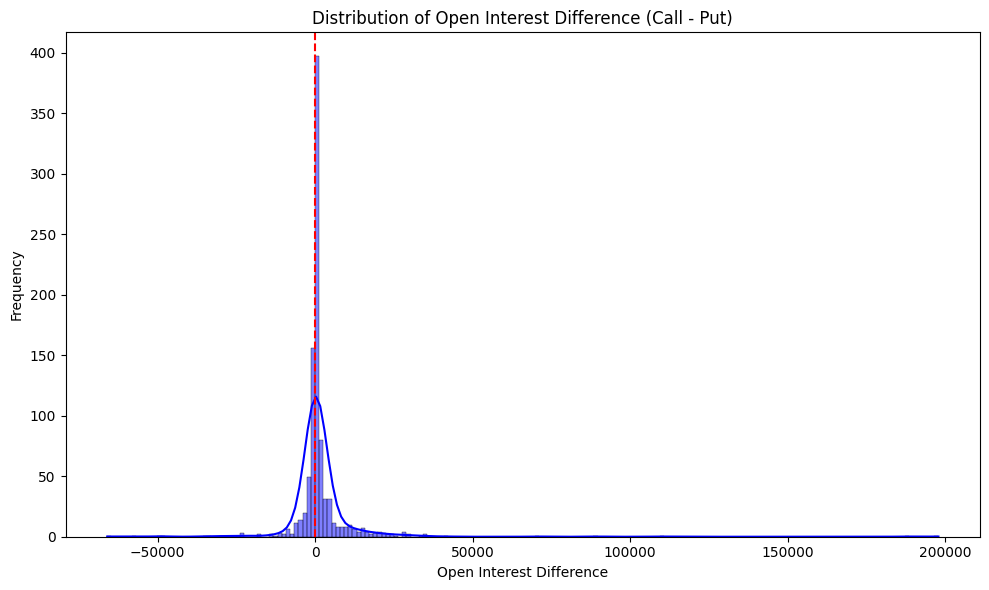

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Split into call and put DataFrames
calls = group[group['type'] == 'call']
puts = group[group['type'] == 'put']

# Merge calls and puts on 'strike' to compare open interest
merged = pd.merge(calls, puts, on=['strike','expiration'], suffixes=('_call', '_put'))

# Compute the difference in open interest
merged['open_interest_diff'] = merged['open_interest_call'] - merged['open_interest_put']

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged['open_interest_diff'], bins=200, kde=True, color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Open Interest Difference (Call - Put)')
plt.xlabel('Open Interest Difference')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


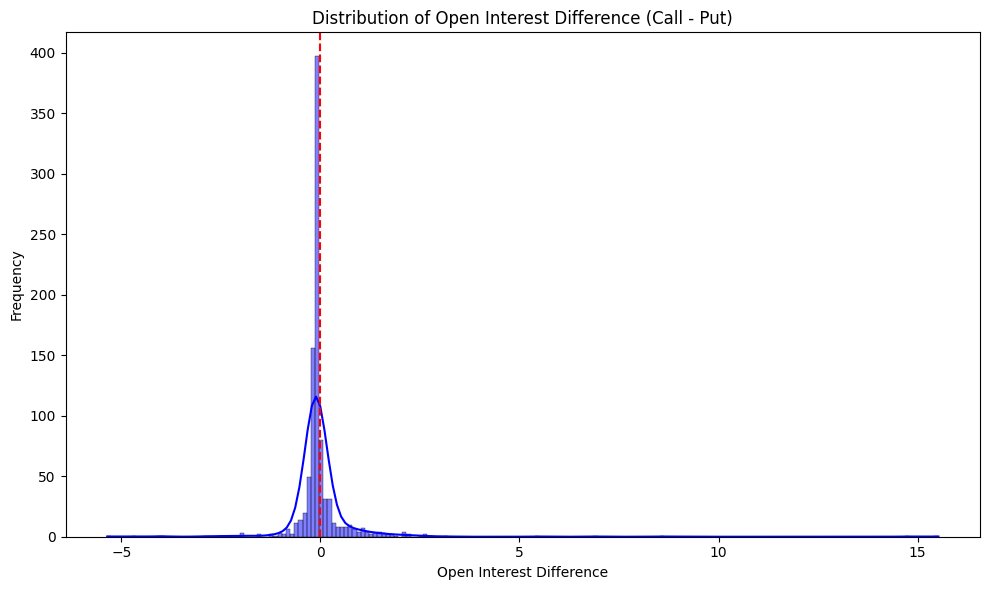

In [21]:
from sklearn.preprocessing import StandardScaler

# Normalize the open interest differences using Z-score normalization
scaler = StandardScaler()
merged['open_interest_diff'] = scaler.fit_transform(merged[['open_interest_diff']])

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged['open_interest_diff'], bins=200, kde=True, color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Open Interest Difference (Call - Put)')
plt.xlabel('Open Interest Difference')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



In [158]:
from scipy.stats import shapiro, normaltest, anderson


merged['open_interest_diff']
# Normality tests
shapiro_stat, shapiro_p = shapiro(merged['open_interest_diff'])
dagostino_stat, dagostino_p = normaltest(merged['open_interest_diff'])


# Display results
print("Shapiro-Wilk Test:")
print(f"  Statistic = {shapiro_stat:.5f}, p-value = {shapiro_p}")

print("\nD’Agostino-Pearson Test:")
print(f"  Statistic = {dagostino_stat:.5f}, p-value = {dagostino_p}")



Shapiro-Wilk Test:
  Statistic = 0.38081, p-value = 1.110776972107209e-55

D’Agostino-Pearson Test:
  Statistic = 1910.16277, p-value = 0.0


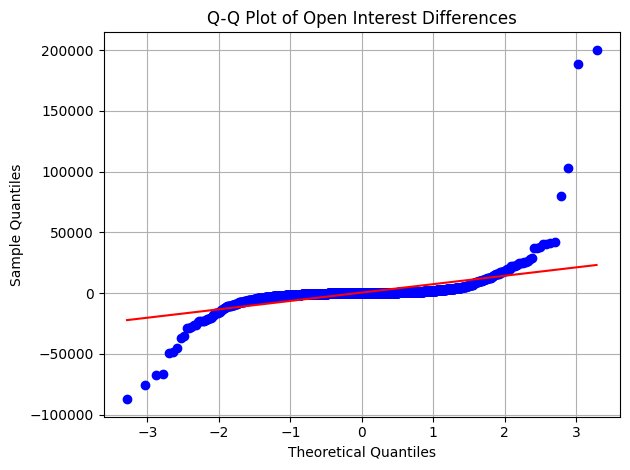

In [153]:
import scipy.stats as stats

plt.figure()
stats.probplot(merged['open_interest_diff'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Open Interest Differences")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.tight_layout()
plt.show()

### Normality Tests and Tail Behavior

We performed two statistical tests to evaluate the normality of the open interest difference distribution:

- **Shapiro–Wilk Test**:  
  Statistic = 0.38081, p-value ≈ 1.11e-55

- **D’Agostino–Pearson Test**:  
  Statistic = 1910.16277, p-value = 0.0

Both tests strongly reject the null hypothesis of normality. Combined with the **QQ plot**, we can clearly observe that the data is **not normally distributed**, especially in the **tails**, which are extremely **heavy**.

However, this behavior is exactly what we are looking for — we **want to capture the extreme values in the tails** to identify **potential key levels as statistical outliers**.

To do this, we will:

1. **First filter the data using a standard Z-score**, assuming normality.
2. Then, to better account for the heavy tails, we will compare this with a **Student’s t-distribution-based Z-score**, which is more appropriate for heavy-tailed data.

This two-step filtering approach helps us detect meaningful outliers while respecting the true statistical nature of the data.

Outliers:
     expiration  strike type_call  last_call  mark_call  bid_call  \
0    2020-02-21   314.0      call      19.43      19.63     19.48   
1    2020-02-21   315.0      call      18.70      18.61     18.48   
2    2020-02-21   316.0      call      17.34      17.63     17.48   
3    2020-02-21   317.0      call      16.72      16.63     16.48   
5    2020-02-21   318.0      call      15.69      15.63     15.48   
...         ...     ...       ...        ...        ...       ...   
1252 2021-01-15   345.0      call      12.42      12.54     12.32   
1257 2021-01-15   350.0      call      10.17      10.02      9.83   
1278 2021-03-19   331.0      call      21.58      22.55     22.23   
1316 2021-12-17   320.0      call      36.25      35.75     35.15   
1361 2022-12-16   330.0      call      35.55      36.22     35.17   

      bid_size_call  ask_call  ask_size_call  volume_call  ...  \
0                 5     19.79              5           34  ...   
1                 5     18.74

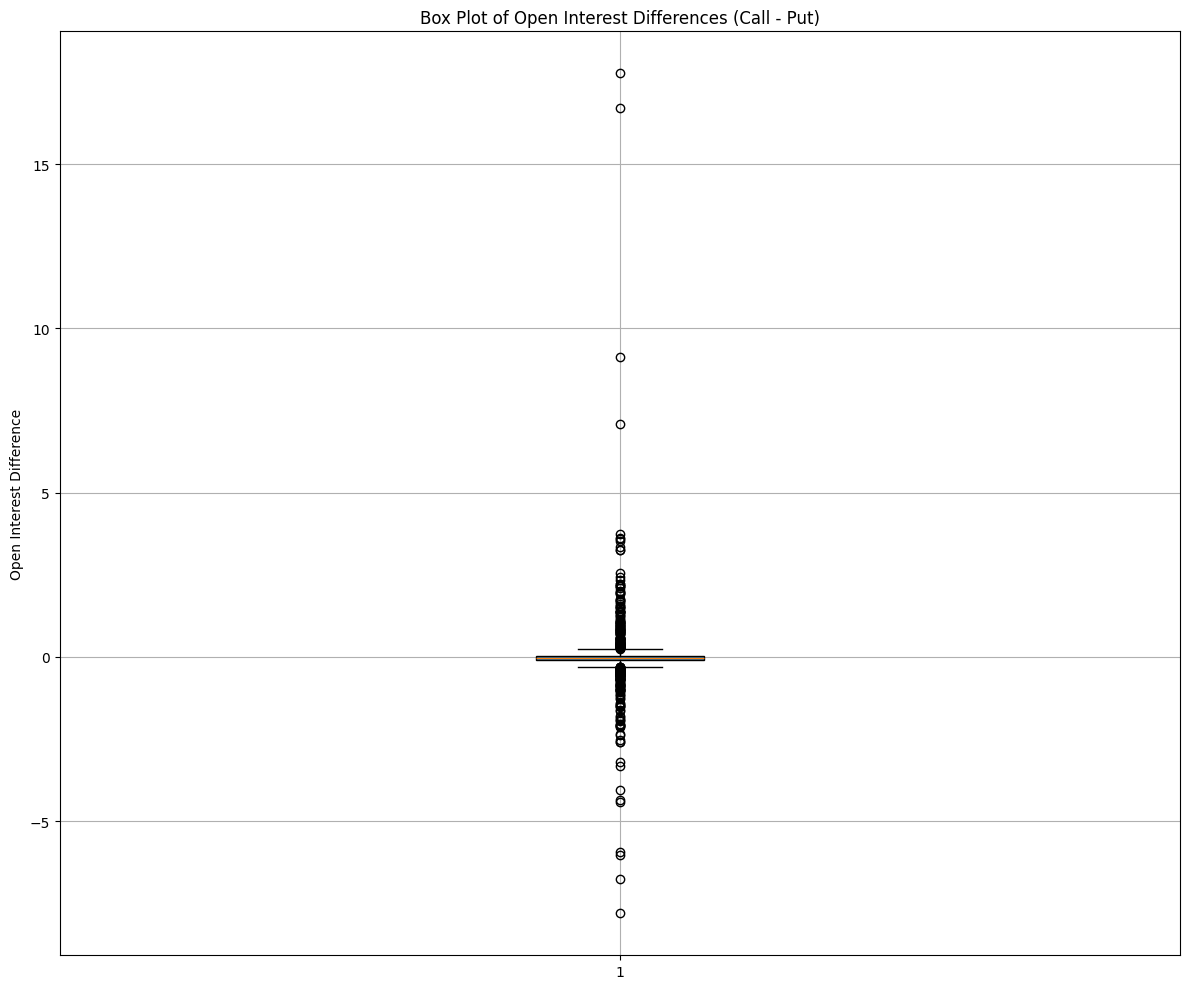

In [ ]:
# 1. Calcul de l'IQR (Interquartile Range)
Q1 = merged['open_interest_diff'].quantile(0.25)
Q3 = merged['open_interest_diff'].quantile(0.75)
IQR = Q3 - Q1

# 2. Définir les bornes pour les outliers
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

# 3. Filtrer les outliers
outliers_df = merged[(merged['open_interest_diff'] < lower_bound) | (merged['open_interest_diff'] > upper_bound)]

# 4. Afficher et sauvegarder les outliers
print("Outliers:")
print(outliers_df)

# (Optionnel) Sauvegarder dans un fichier CSV
outliers_df.to_csv("outliers_oi_diff.csv", index=False)

# 5. Tracer le boxplot

plt.boxplot(merged['open_interest_diff'], vert=True, patch_artist=True)
plt.title('Box Plot of Open Interest Differences (Call - Put)')
plt.ylabel('Open Interest Difference')
plt.grid(True)
plt.tight_layout()
plt.show()

Outliers (Z-score > ±2.5):
    expiration  strike type_call  last_call  mark_call  bid_call  \
2   2020-02-14   327.0      call      10.60      10.73     10.64   
6   2020-02-14   330.0      call       7.58       7.71      7.62   
10  2020-02-14   333.0      call       4.60       4.69      4.62   
12  2020-02-14   334.0      call       3.58       3.69      3.62   
48  2020-02-18   334.0      call       3.85       3.91      3.86   
79  2020-02-19   339.0      call       0.66       0.67      0.66   
91  2020-02-21   325.0      call      12.82      12.95     12.86   
92  2020-02-21   326.0      call      11.80      11.97     11.88   
93  2020-02-21   327.0      call      10.56      11.00     10.91   
103 2020-02-21   335.0      call       3.64       3.69      3.67   
108 2020-02-21   339.0      call       1.11       1.10      1.09   
109 2020-02-21   340.0      call       0.71       0.70      0.70   
110 2020-02-21   341.0      call       0.44       0.43      0.43   
111 2020-02-21   342.

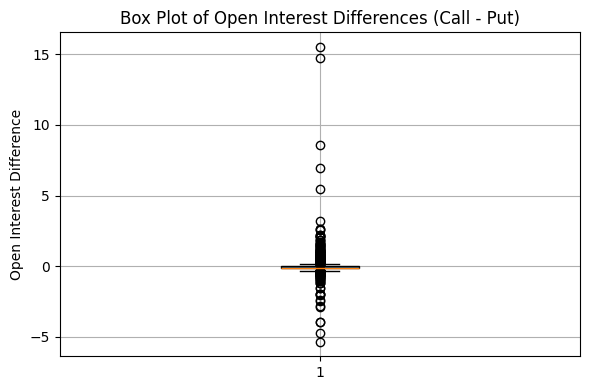

In [22]:
# 1. Calcul du Z-score
mean = merged['open_interest_diff'].mean()
std = merged['open_interest_diff'].std()

# Z-score = (valeur - moyenne) / écart-type
merged['z_score'] = (merged['open_interest_diff'] - mean) / std

# 2. Définir les outliers (par ex. seuil = 2.5)
threshold = 1.5
outliers_df = merged[(merged['z_score'].abs() > threshold)]

# 3. Afficher les outliers
print("Outliers (Z-score > ±2.5):")
print(outliers_df)

# 4. (Optionnel) Sauvegarder dans un fichier CSV
outliers_df.to_csv("outliers_oi_diff_zscore.csv", index=False)

# 5. Tracer le boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(merged['open_interest_diff'], vert=True, patch_artist=True)
plt.title('Box Plot of Open Interest Differences (Call - Put)')
plt.ylabel('Open Interest Difference')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
merged = merged[(merged['expiration']=='2020-02-21')]
outliers_df = outliers_df[(outliers_df['expiration']=='2020-02-21')]

C:\Users\hp\AppData\Local\Temp\ipykernel_9848\2095830139.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_sorted, y=y_sorted, palette='coolwarm')
C:\Users\hp\AppData\Local\Temp\ipykernel_9848\2095830139.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


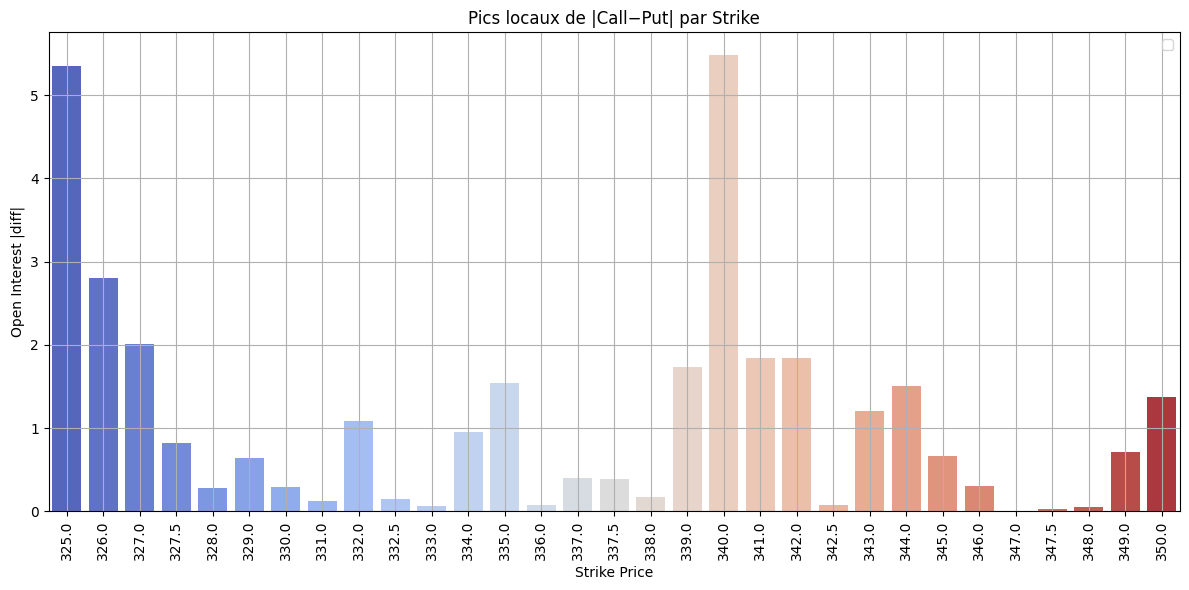

   strike_peak  oi_diff_abs
0        325.0     5.353047
1        329.0     0.645280
2        332.0     1.078905
3        335.0     1.545354
4        337.0     0.403202
5        340.0     5.480742
6        342.0     1.845350
7        344.0     1.505639
8        350.0     1.372492


In [24]:
# 1. Préparer et trier
x = merged['strike'].values
y = np.abs(merged['open_interest_diff'].values)
order = np.argsort(x)
x_sorted = x[order]
y_sorted = y[order]

# 2. Détecter les pics locaux
peak_indices = []
for i in range(len(y_sorted)):
    if i == 0:
        if y_sorted[i] > y_sorted[i+1]:
            peak_indices.append(i)
    elif i == len(y_sorted)-1:
        if y_sorted[i] > y_sorted[i-1]:
            peak_indices.append(i)
    else:
        if y_sorted[i] > y_sorted[i-1] and y_sorted[i] > y_sorted[i+1]:
            peak_indices.append(i)

peak_strikes = x_sorted[peak_indices]
peak_values = y_sorted[peak_indices]

# 3. Tracer le barplot + pics
plt.figure(figsize=(12, 6))
sns.barplot(x=x_sorted, y=y_sorted, palette='coolwarm')

plt.title('Pics locaux de |Call−Put| par Strike')
plt.xlabel('Strike Price')
plt.ylabel('Open Interest |diff|')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Afficher les résultats
peaks_df = pd.DataFrame({
    'strike_peak': peak_strikes,
    'oi_diff_abs': peak_values
})
print(peaks_df)

C:\Users\hp\AppData\Local\Temp\ipykernel_9848\2750727469.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outliers_df['strike'], y=np.abs(outliers_df['open_interest_diff']), palette='coolwarm')
C:\Users\hp\AppData\Local\Temp\ipykernel_9848\2750727469.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


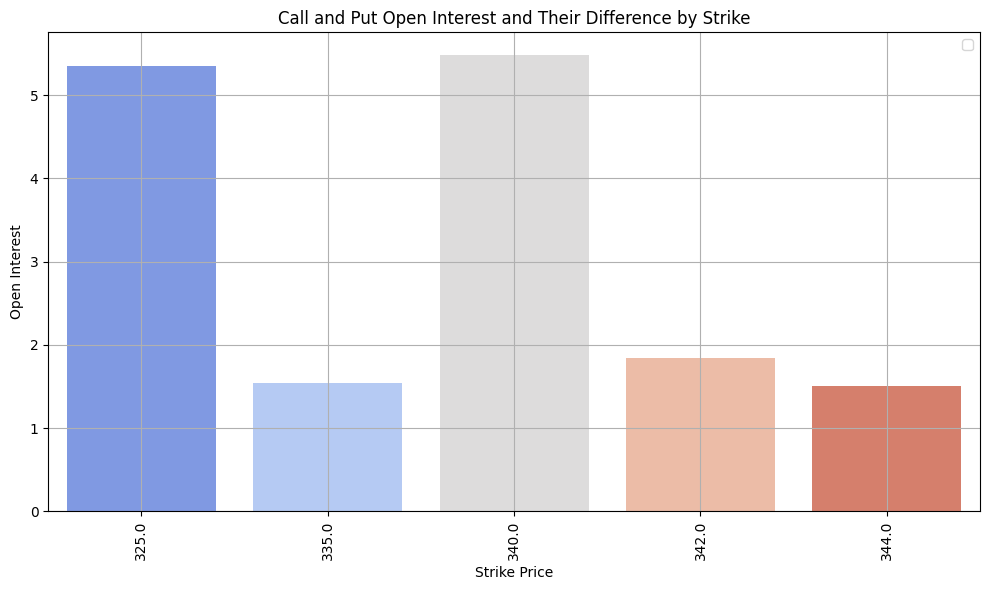

In [25]:
plt.figure(figsize=(10, 6))

outliers_df = outliers_df[outliers_df['strike'].isin(peaks_df['strike_peak'])]

# Plot difference (Call - Put)
sns.barplot(x=outliers_df['strike'], y=np.abs(outliers_df['open_interest_diff']), palette='coolwarm')
plt.title('Call and Put Open Interest and Their Difference by Strike')
plt.xlabel('Strike Price')
plt.ylabel('Open Interest')
plt.xticks(rotation=90) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## student test 

Fitted t-distribution parameters:
  degrees of freedom (df) = 0.569
  location = -0.125
  scale = 0.031


Kolmogorov–Smirnov Test against t(df=0.57, loc=-0.13, scale=0.03):
  KS statistic = 0.12302, p-value = 0.00000
  → Reject the null hypothesis: data are unlikely from a t-distribution.


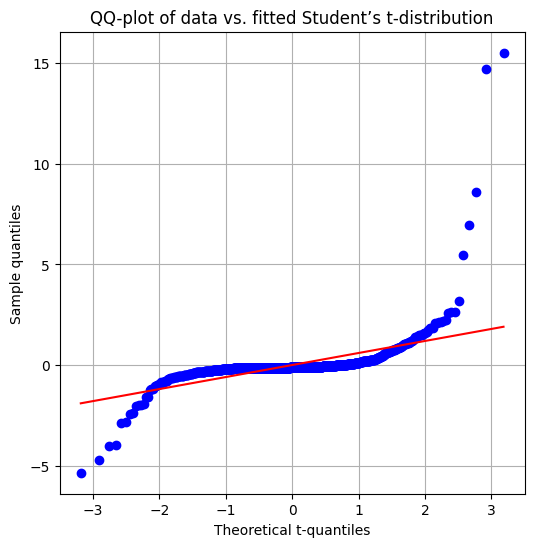

In [30]:
from scipy.stats import t, kstest, probplot
from sklearn.preprocessing import StandardScaler

# Normalize the open interest differences using Z-score normalization
scaler = StandardScaler()
merged['open_interest_diff'] = scaler.fit_transform(merged[['open_interest_diff']])
data = merged['open_interest_diff'].dropna().values


# 1. Fit t-distribution to the data
df, loc, scale = t.fit(data)
print(f"Fitted t-distribution parameters:\n"
      f"  degrees of freedom (df) = {df:.3f}\n"
      f"  location = {loc:.3f}\n"
      f"  scale = {scale:.3f}\n")

# 2. Kolmogorov–Smirnov test against the fitted t-distribution
ks_stat, ks_p = kstest(data, 't', args=(df, loc, scale))
print(f"\nKolmogorov–Smirnov Test against t(df={df:.2f}, loc={loc:.2f}, scale={scale:.2f}):")
print(f"  KS statistic = {ks_stat:.5f}, p-value = {ks_p:.5f}")

if ks_p > 0.05:
    print("  → Cannot reject the null hypothesis: data are consistent with a t-distribution.")
else:
    print("  → Reject the null hypothesis: data are unlikely from a t-distribution.")

# 3. (Optional) QQ-plot against theoretical t-distribution
plt.figure(figsize=(6,6))
probplot(data, dist=t, sparams=(len(data)-1, 0, 1), plot=plt)
plt.title("QQ-plot of data vs. fitted Student’s t-distribution")
plt.xlabel("Theoretical t-quantiles")
plt.ylabel("Sample quantiles")
plt.grid(True)
plt.show()

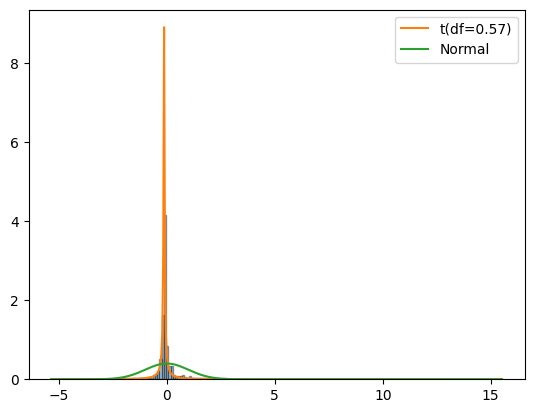

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm, laplace

data = merged['open_interest_diff'].dropna().values
params_t = t.fit(data)
params_norm = norm.fit(data)
params_lap = laplace.fit(data)
plt.hist(data, bins=200, density=True, alpha=0.4, edgecolor='k')
xs = np.linspace(data.min(), data.max(), 500)
plt.plot(xs, t.pdf(xs, *params_t),   label=f"t(df={params_t[0]:.2f})")
plt.plot(xs, norm.pdf(xs, *params_norm), label="Normal")

plt.legend()
plt.show()


Outliers (Studentized Z-score > ±1.282):
    expiration  strike type_call  last_call  mark_call  bid_call  \
2   2020-02-14   327.0      call      10.60      10.73     10.64   
6   2020-02-14   330.0      call       7.58       7.71      7.62   
10  2020-02-14   333.0      call       4.60       4.69      4.62   
12  2020-02-14   334.0      call       3.58       3.69      3.62   
48  2020-02-18   334.0      call       3.85       3.91      3.86   
79  2020-02-19   339.0      call       0.66       0.67      0.66   
91  2020-02-21   325.0      call      12.82      12.95     12.86   
92  2020-02-21   326.0      call      11.80      11.97     11.88   
93  2020-02-21   327.0      call      10.56      11.00     10.91   
103 2020-02-21   335.0      call       3.64       3.69      3.67   
108 2020-02-21   339.0      call       1.11       1.10      1.09   
109 2020-02-21   340.0      call       0.71       0.70      0.70   
110 2020-02-21   341.0      call       0.44       0.43      0.43   
111 202

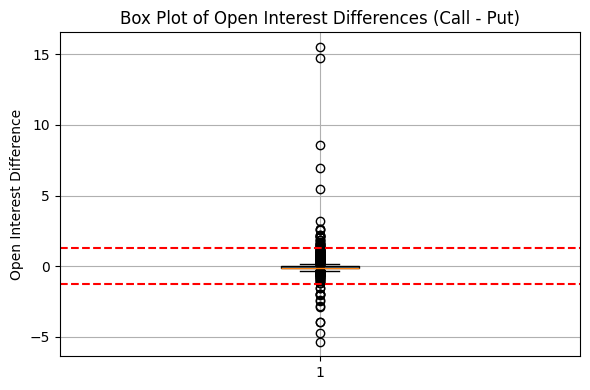

In [32]:
# 1. Calcul du Z-score étudiant
mean = merged['open_interest_diff'].mean()
std = merged['open_interest_diff'].std()

n = len(merged['open_interest_diff'])
merged['z_score'] = (merged['open_interest_diff'] - mean) / (std * np.sqrt(1 - 1/n))

# 2. Définir les outliers (seuil = quantile t à 95%)
threshold = t.ppf(0.90, df=n-1)
outliers_df = merged[(merged['z_score'].abs() > threshold)]

# 3. Afficher les outliers
print(f"Outliers (Studentized Z-score > ±{threshold:.3f}):")
print(outliers_df)



# 5. Tracer le boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(merged['open_interest_diff'], vert=True, patch_artist=True)
plt.title('Box Plot of Open Interest Differences (Call - Put)')
plt.ylabel('Open Interest Difference')
plt.axhline(mean + threshold * std * np.sqrt(1 - 1/n), color='r', linestyle='--')
plt.axhline(mean - threshold * std * np.sqrt(1 - 1/n), color='r', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
merged = merged[(merged['expiration']=='2020-02-21')]
outliers_df = outliers_df[(outliers_df['expiration']=='2020-02-21')]

C:\Users\hp\AppData\Local\Temp\ipykernel_9848\2598562205.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_sorted, y=y_sorted, palette='coolwarm')
C:\Users\hp\AppData\Local\Temp\ipykernel_9848\2598562205.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


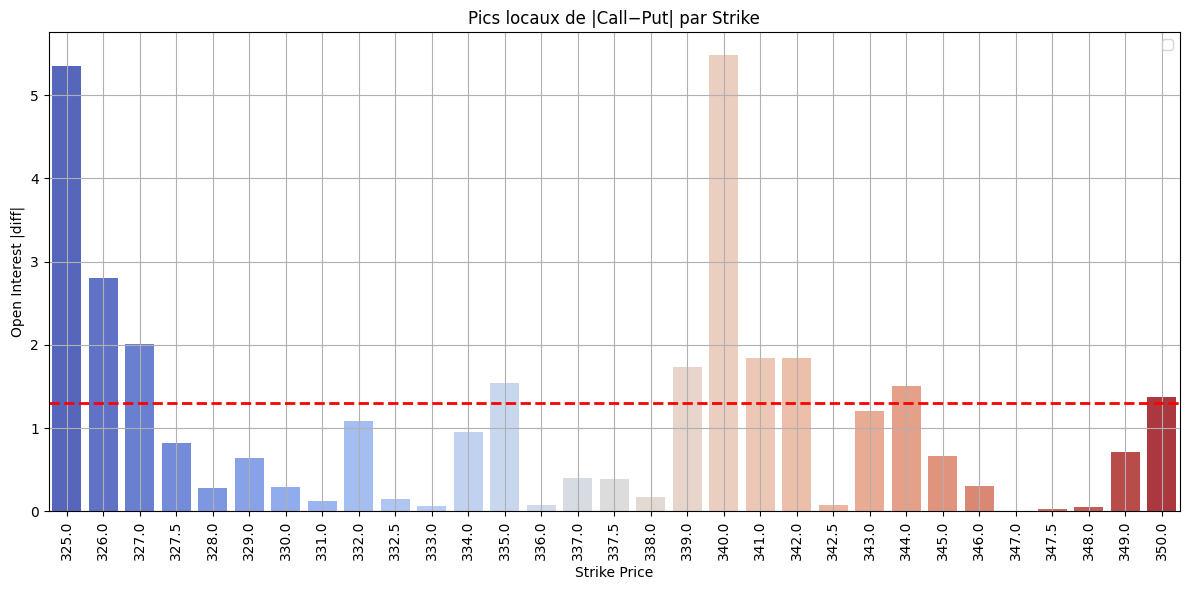

   strike_peak  oi_diff_abs
0        325.0     5.353047
1        329.0     0.645280
2        332.0     1.078905
3        335.0     1.545354
4        337.0     0.403202
5        340.0     5.480742
6        342.0     1.845350
7        344.0     1.505639
8        350.0     1.372492


In [42]:
# 1. Préparer et trier
x = merged['strike'].values
y = np.abs(merged['open_interest_diff'].values)
order = np.argsort(x)
x_sorted = x[order]
y_sorted = y[order]

# 2. Détecter les pics locaux
peak_indices = []
for i in range(len(y_sorted)):
    if i == 0:
        if y_sorted[i] > y_sorted[i+1]:
            peak_indices.append(i)
    elif i == len(y_sorted)-1:
        if y_sorted[i] > y_sorted[i-1]:
            peak_indices.append(i)
    else:
        if y_sorted[i] > y_sorted[i-1] and y_sorted[i] > y_sorted[i+1]:
            peak_indices.append(i)

peak_strikes = x_sorted[peak_indices]
peak_values = y_sorted[peak_indices]

# 3. Tracer le barplot + pics
plt.figure(figsize=(12, 6))
sns.barplot(x=x_sorted, y=y_sorted, palette='coolwarm')
plt.axhline(1.3, color='red', linestyle='--', linewidth=2)
plt.title('Pics locaux de |Call−Put| par Strike')
plt.xlabel('Strike Price')
plt.ylabel('Open Interest |diff|')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 4. Afficher les résultats
peaks_df = pd.DataFrame({
    'strike_peak': peak_strikes,
    'oi_diff_abs': peak_values
})
print(peaks_df)

C:\Users\hp\AppData\Local\Temp\ipykernel_9848\2750727469.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outliers_df['strike'], y=np.abs(outliers_df['open_interest_diff']), palette='coolwarm')
C:\Users\hp\AppData\Local\Temp\ipykernel_9848\2750727469.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


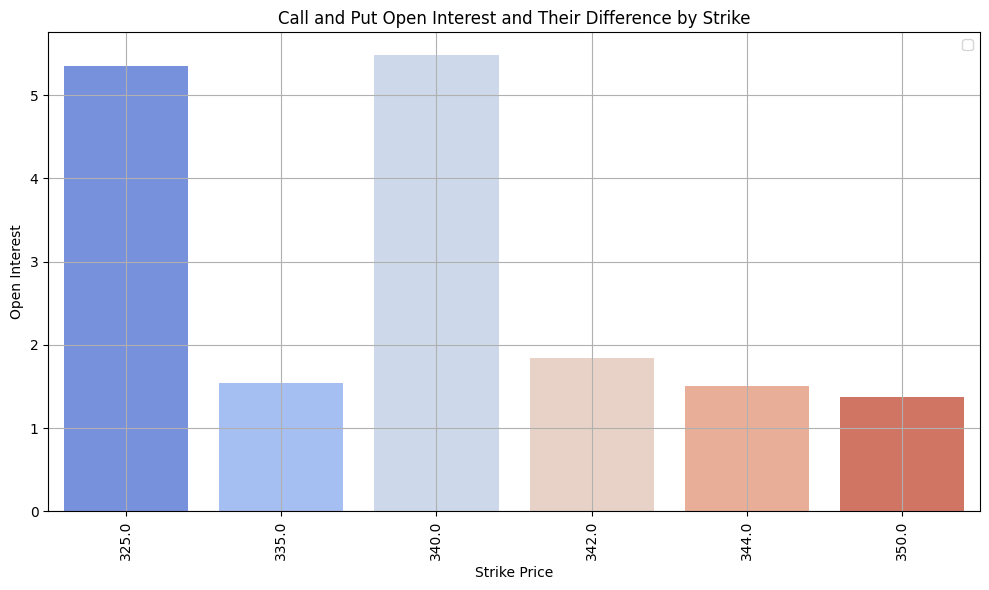

In [43]:
plt.figure(figsize=(10, 6))

outliers_df = outliers_df[outliers_df['strike'].isin(peaks_df['strike_peak'])]

# Plot difference (Call - Put)
sns.barplot(x=outliers_df['strike'], y=np.abs(outliers_df['open_interest_diff']), palette='coolwarm')
plt.title('Call and Put Open Interest and Their Difference by Strike')
plt.xlabel('Strike Price')
plt.ylabel('Open Interest')
plt.xticks(rotation=90) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
print(weekly_em_df[weekly_em_df['Day_of_calculation']=='2025-03-14'])

    Day_of_calculation Expiration   Close         EM  em_straddle    em_high  \
271         2025-03-14 2025-03-21  562.73  16.929045       13.515  13.887841   

        em_low  delta_low  delta_high  
271  19.970249     -19.73       13.27  


# Gamma exposer 

In [16]:
daily_close

,date,close
0,2014-07-03,198.20
1,2014-07-07,197.54
2,2014-07-08,196.27
3,2014-07-09,197.13
4,2014-07-10,196.34
...,...,...
2689,2025-03-13,551.42
2690,2025-03-14,562.73
2691,2025-03-17,567.15
2692,2025-03-18,561.02


In [44]:
# First ensure 'date' column in both DataFrames is datetime
option['date'] = pd.to_datetime(option['date'])
daily_close['date'] = pd.to_datetime(daily_close['date'])

# Map close price from daily_close to option rows
option = option.merge(daily_close[['date', 'close']], on='date', how='left')
option.rename(columns={'close': 'underlying_close'}, inplace=True)



In [45]:
option.dropna(inplace=True)

In [ ]:
# Then compute GEX
option['gex'] = option.apply(
    lambda row: row['gamma'] * row['open_interest'] * (row['underlying_close'] ** 2) * 100 * 
                (0.01 if row['type'].lower() == 'call' else -0.01),
    axis=1
)
option

In [46]:
option['dte'] = (option['expiration'] - option['date']).dt.days
option.to_csv("option_gex.csv", index=False)

In [47]:
import pandas as pd 
option =  pd.read_csv("option_gex.csv")

In [54]:
# Make sure both 'date' and 'expiration' are datetime types
option['date'] = pd.to_datetime(option['date'])
option['expiration'] = pd.to_datetime(option['expiration'])

In [55]:
grouped = option.groupby('date')
group_key = list(grouped.groups.keys())[1] #get the option's chain of a random friday 
group = grouped.get_group(group_key)
group

,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,...,implied_volatility,delta,gamma,theta,vega,rho,week,underlying_close,dte,gex
7470,2020-01-06,265.0,call,0.00,58.81,58.45,11,59.17,22,0,...,1.78580,0.98558,0.00121,-0.56460,0.00620,0.00713,2020-01-04/2020-01-10,323.67,0,0.000000
7471,2020-01-06,265.0,put,0.01,0.01,0.00,0,0.01,5396,0,...,1.30669,-0.00155,0.00023,-0.05564,0.00085,-0.00001,2020-01-04/2020-01-10,323.67,0,-8698.411187
7472,2020-01-06,270.0,call,0.00,53.81,53.45,11,54.17,22,0,...,1.63946,0.98442,0.00141,-0.55447,0.00663,0.00725,2020-01-04/2020-01-10,323.67,0,0.000000
7473,2020-01-06,270.0,put,0.00,0.01,0.00,0,0.01,5060,0,...,1.19404,-0.00169,0.00027,-0.05492,0.00092,-0.00002,2020-01-04/2020-01-10,323.67,0,-6703.737587
7474,2020-01-06,275.0,call,0.00,48.81,48.45,11,49.17,22,0,...,1.49449,0.98306,0.00166,-0.54338,0.00712,0.00738,2020-01-04/2020-01-10,323.67,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14747,2022-12-16,390.0,put,0.00,73.22,70.95,50,75.50,10,0,...,0.18797,-0.60849,0.00368,-0.00718,2.13335,-7.95671,2020-01-04/2020-01-10,323.67,1075,-0.000000
14748,2022-12-16,395.0,call,8.78,8.57,7.32,411,9.83,4,0,...,0.11495,0.24826,0.00496,-0.01245,1.75843,2.11366,2020-01-04/2020-01-10,323.67,1075,1039.241707
14749,2022-12-16,395.0,put,0.00,77.06,74.63,50,79.50,2,0,...,0.18965,-0.62142,0.00361,-0.00682,2.11235,-8.19337,2020-01-04/2020-01-10,323.67,1075,-0.000000
14750,2022-12-16,400.0,call,7.85,7.87,7.00,3,8.74,50,4,...,0.11587,0.23077,0.00473,-0.01194,1.68967,1.96799,2020-01-04/2020-01-10,323.67,1075,19325.495744


In [ ]:

group = group[(group['dte'] >= 1) & (group['dte'] <= 30)]


In [45]:
net_gamma = group.groupby('strike')['gex'].sum().reset_index()
net_gamma =net_gamma[net_gamma['gex'] != 0]

In [46]:
net_gamma

,strike,gex
0,50.0,6.285736
1,60.0,356.191714
2,70.0,5179.446574
3,80.0,1176.480280
4,85.0,110.000382
...,...,...
250,375.0,48735.407492
251,380.0,22880.079528
252,385.0,24811.895766
255,400.0,71424.819691


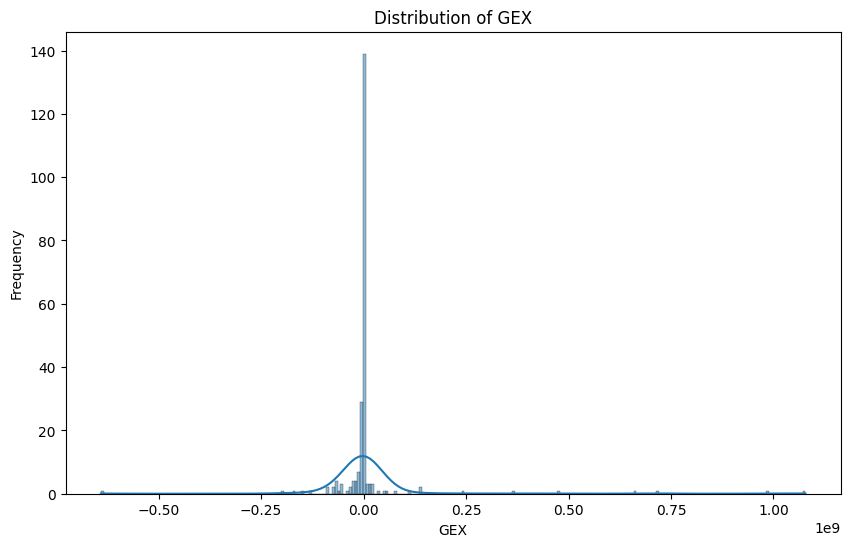

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
net_gamma['gex_scaled'] = scaler.fit_transform(net_gamma[['gex']])

plt.figure(figsize=(10, 6))
sns.histplot(net_gamma['gex'], bins=250, kde=True)
plt.title('Distribution of GEX')
plt.xlabel('GEX')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

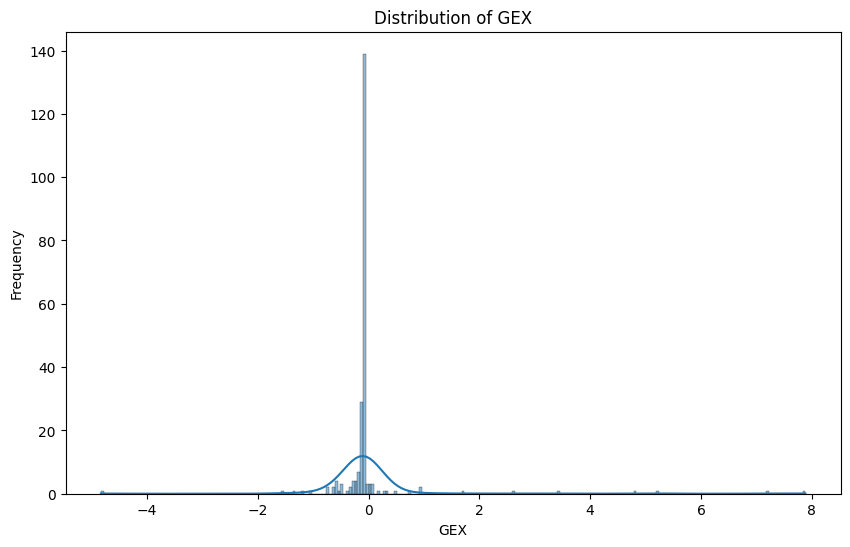

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(net_gamma['gex_scaled'], bins=250, kde=True)
plt.title('Distribution of GEX')
plt.xlabel('GEX')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

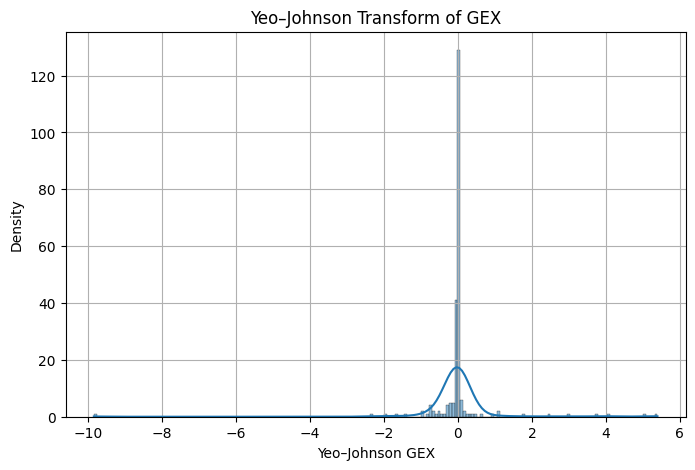

In [49]:
from sklearn.preprocessing import PowerTransformer


pt = PowerTransformer(method='yeo-johnson', standardize=True)
net_gamma['gex_yeo'] = pt.fit_transform(net_gamma[['gex_scaled']]).flatten()

# b) Plot
plt.figure(figsize=(8, 5))
sns.histplot(net_gamma['gex_yeo'] , bins=200, kde=True)
plt.title("Yeo–Johnson Transform of GEX")
plt.xlabel("Yeo–Johnson GEX")
plt.ylabel("Density")
plt.grid(True)
plt.show()

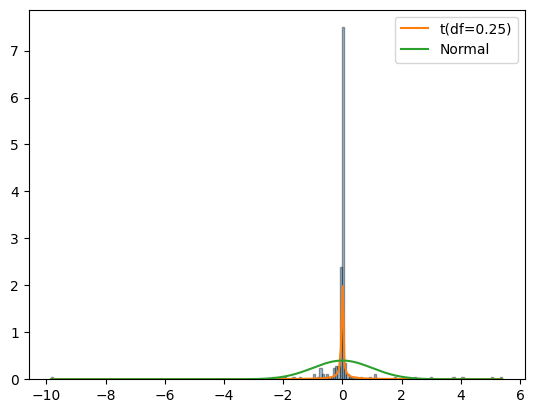

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm, laplace


params_t = t.fit(net_gamma['gex_yeo'] )
params_norm = norm.fit(net_gamma['gex_yeo'] )
params_lap = laplace.fit(net_gamma['gex_yeo'] )
plt.hist(net_gamma['gex_yeo'] , bins=200, density=True, alpha=0.4, edgecolor='k')
xs = np.linspace(net_gamma['gex_yeo'] .min(), net_gamma['gex_yeo'] .max(), 250)
plt.plot(xs, t.pdf(xs, *params_t),   label=f"t(df={params_t[0]:.2f})")
plt.plot(xs, norm.pdf(xs, *params_norm), label="Normal")

plt.legend()
plt.show()

Fitted t-distribution parameters:
  degrees of freedom (df) = 0.255
  location = 0.020
  scale = 0.001



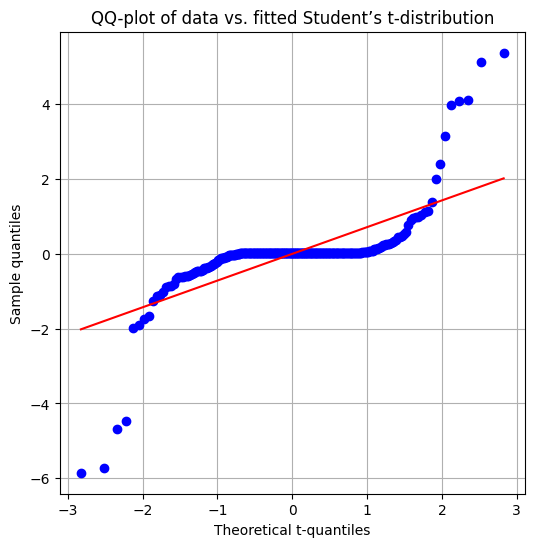

In [95]:
from scipy.stats import t, probplot
from sklearn.preprocessing import StandardScaler


# 1. Fit t-distribution to the data
df, loc, scale = t.fit(net_gamma['gex_yeo'])
print(f"Fitted t-distribution parameters:\n"
      f"  degrees of freedom (df) = {df:.3f}\n"
      f"  location = {loc:.3f}\n"
      f"  scale = {scale:.3f}\n")


# 3. (Optional) QQ-plot against theoretical t-distribution
plt.figure(figsize=(6,6))
probplot(net_gamma['gex_yeo'] , dist=t, sparams=(len(net_gamma['gex_yeo'])-1, 0, 1), plot=plt)
plt.title("QQ-plot of data vs. fitted Student’s t-distribution")
plt.xlabel("Theoretical t-quantiles")
plt.ylabel("Sample quantiles")
plt.grid(True)
plt.show()

Outliers (Studentized t-score > ±1.285):
     strike           gex  gex_scaled   gex_yeo   t_score
188   316.0 -1.293447e+08   -1.045293 -1.434816 -1.434816
190   317.0 -1.489718e+08   -1.190450 -1.682965 -1.682965
192   318.0 -1.705138e+08   -1.349767 -1.963721 -1.963721
194   319.0 -1.982216e+08   -1.554685 -2.337231 -2.337231
196   320.0 -6.410080e+08   -4.829390 -9.836210 -9.836210
202   323.0  4.792983e+08    3.456032  2.987870  2.987870
204   324.0  2.448318e+08    1.721994  1.759761  1.759761
206   325.0  1.078043e+09    7.884150  5.393020  5.393020
208   326.0  6.598369e+08    4.791237  3.793509  3.793509
210   327.0  7.177261e+08    5.219367  4.034097  4.034097
212   328.0  3.688340e+08    2.639074  2.441761  2.441761
216   330.0  9.864747e+08    7.206944  5.066884  5.066884


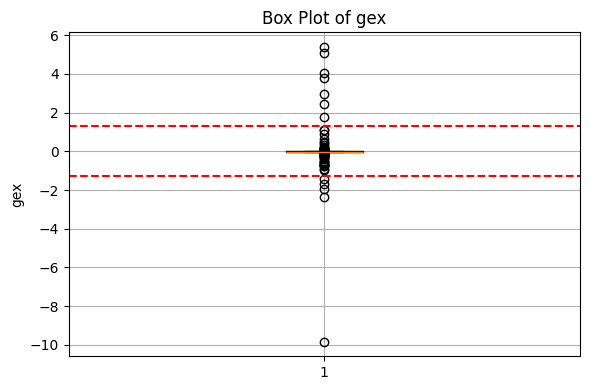

In [53]:
from scipy.stats import t
# 1. Calcul du t-score étudiant
mean = net_gamma['gex_yeo'].mean()
std = net_gamma['gex_yeo'].std()

n = len(net_gamma['gex_yeo'])
net_gamma['t_score'] = (net_gamma['gex_yeo'] - mean) / (std * np.sqrt(1 - 1/n))

# 2. Définir les outliers (seuil = quantile t à 95%)
threshold = t.ppf(0.90, df=n-1)
outliers_df = net_gamma[(net_gamma['t_score'].abs() > threshold)]

# 3. Afficher les outliers
print(f"Outliers (Studentized t-score > ±{threshold:.3f}):")
print(outliers_df)



# 5. Tracer le boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(net_gamma['gex_yeo'], vert=True, patch_artist=True)
plt.title('Box Plot of gex')
plt.ylabel('gex')
plt.axhline(mean + threshold * std * np.sqrt(1 - 1/n), color='r', linestyle='--')
plt.axhline(mean - threshold * std * np.sqrt(1 - 1/n), color='r', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_10376\2497649559.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_sorted, y=y_sorted, palette='coolwarm')
C:\Users\hp\AppData\Local\Temp\ipykernel_10376\2497649559.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


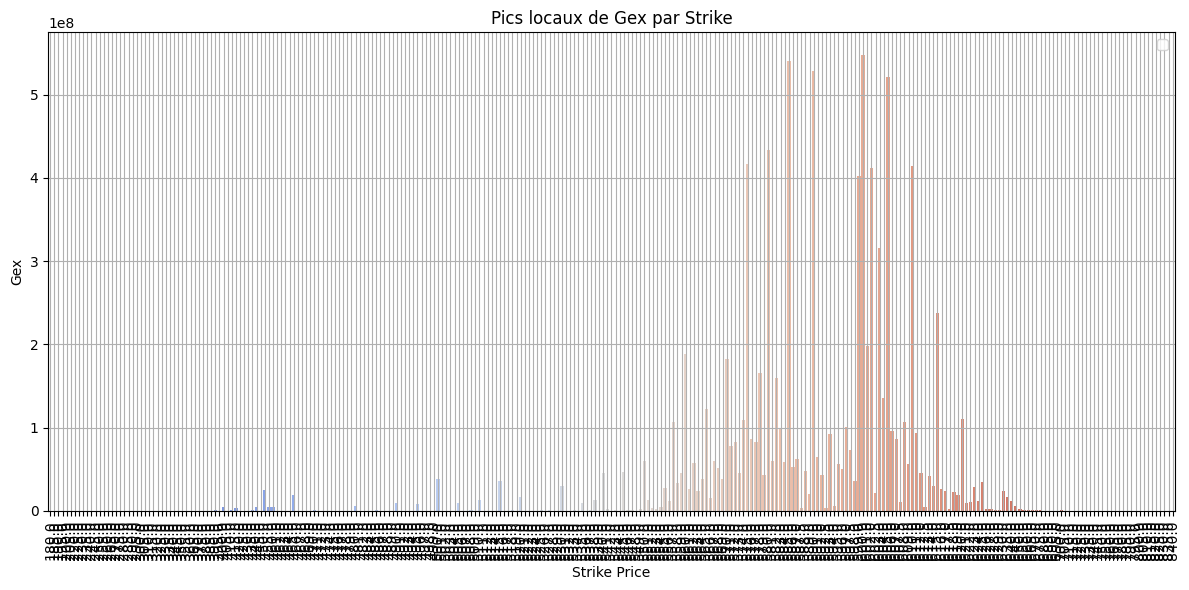

    strike_peak            gex
0         180.0    1687.198801
1         200.0    1010.192559
2         235.0   18179.921533
3         250.0  117745.917998
4         265.0   28221.590027
..          ...            ...
84        745.0   76246.498752
85        770.0  124328.120042
86        795.0  149490.776109
87        810.0   89251.398753
88        840.0    5518.841456

[89 rows x 2 columns]


In [44]:
# 1. Préparer et trier
x = net_gamma['strike'].values
y = np.abs(net_gamma['gex'].values)
order = np.argsort(x)
x_sorted = x[order]
y_sorted = y[order]

# 2. Détecter les pics locaux
peak_indices = []
for i in range(len(y_sorted)):
    if i == 0:
        if y_sorted[i] > y_sorted[i+1]:
            peak_indices.append(i)
    elif i == len(y_sorted)-1:
        if y_sorted[i] > y_sorted[i-1]:
            peak_indices.append(i)
    else:
        if y_sorted[i] > y_sorted[i-1] and y_sorted[i] > y_sorted[i+1]:
            peak_indices.append(i)

peak_strikes = x_sorted[peak_indices]
peak_values = y_sorted[peak_indices]

# 3. Tracer le barplot + pics
plt.figure(figsize=(12, 6))
sns.barplot(x=x_sorted, y=y_sorted, palette='coolwarm')

plt.title('Pics locaux de Gex par Strike')
plt.xlabel('Strike Price')
plt.ylabel('Gex')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Afficher les résultats
peaks_df = pd.DataFrame({
    'strike_peak': peak_strikes,
    'gex': peak_values
})
print(peaks_df)

C:\Users\hp\AppData\Local\Temp\ipykernel_10376\1273317872.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outliers_df['strike'], y=np.abs(outliers_df['gex']), palette='coolwarm')
C:\Users\hp\AppData\Local\Temp\ipykernel_10376\1273317872.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


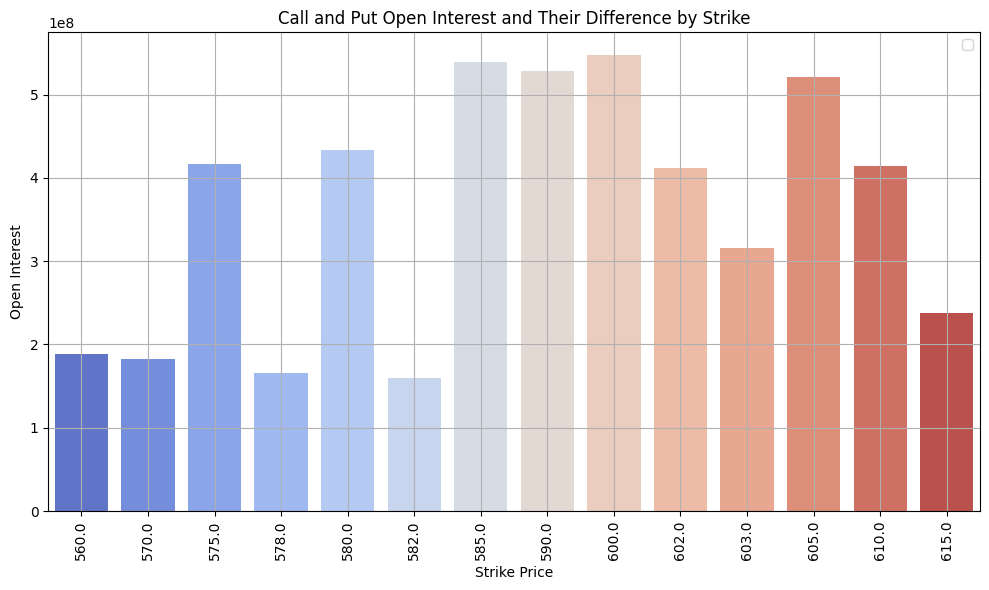

In [45]:
plt.figure(figsize=(10, 6))

outliers_df = outliers_df[outliers_df['strike'].isin(peaks_df['strike_peak'])]

# Plot difference (Call - Put)
sns.barplot(x=outliers_df['strike'], y=np.abs(outliers_df['gex']), palette='coolwarm')
plt.title('Call and Put Open Interest and Their Difference by Strike')
plt.xlabel('Strike Price')
plt.ylabel('Open Interest')
plt.xticks(rotation=90) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create the final data 

In [56]:
import numpy as np
import pandas as pd
from scipy.stats import t

def detect_options_outlier_peaks(df: pd.DataFrame, close: float, em: float, expiration_date: str) -> pd.DataFrame:
    # Filters by strike ∈ [close±3*em], computes a Student-t Z-score on open_interest_diff,
    # finds outliers at |z| > t.ppf(0.90, n-1), then keeps only those with expiration == expiration_date
    # whose strike is a local peak in |open_interest_diff|.
   
    df = df[(df['strike'] >= close - 3*em) & (df['strike'] <= close + 3*em)]
    # Split into call and put DataFrames
    calls = df[df['type'] == 'call']
    puts = df[df['type'] == 'put']

    # Merge calls and puts on 'strike' to compare open interest
    merged = pd.merge(calls, puts, on=['strike','expiration'], suffixes=('_call', '_put'))

    # Compute the difference in open interest
    merged['open_interest_diff'] = merged['open_interest_call'] - merged['open_interest_put']
    # 1. Compute Student-t Z-score over the entire data
    mean_val = merged['open_interest_diff'].mean()
    std_val = merged['open_interest_diff'].std()
    n = len(merged['open_interest_diff'])
    
    # Avoid division by zero if std is zero (all values identical)
    if std_val == 0 or n <= 1:
        # In that degenerate case, there are no valid Z-scores: return empty
        return pd.DataFrame(columns=df.columns.tolist() + ['z_score'])
    
    merged['z_score'] = (
        (merged['open_interest_diff'] - mean_val)
        / (std_val * np.sqrt(1 - 1/n))
    )

    # 2. Identify outliers: |z_score| > t.ppf(0.90, df=n-1)
    threshold = t.ppf(0.90, df=n-1)
    outliers_all = merged.loc[merged['z_score'].abs() > threshold].copy()

    # 3. Filter both datasets to the requested expiration_date
    merged_exp = merged.loc[merged['expiration'] == expiration_date].copy()
    outliers_exp = outliers_all.loc[outliers_all['expiration'] == expiration_date].copy()

    # If there are no rows for that expiration at all, return an empty DataFrame
    if merged_exp.empty or outliers_exp.empty:
        return pd.DataFrame(columns=df.columns.tolist() + ['z_score'])

    # 4. Detect local peaks in |open_interest_diff| vs strike, within merged_exp
    x = merged_exp['strike'].values
    y = np.abs(merged_exp['open_interest_diff'].values)

    # Sort by strike so that “neighbors” are correctly identified
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    peak_indices = []
    L = len(y_sorted)
    for i in range(L):
        if i == 0:
            # first point: compare only to next
            if L > 1 and y_sorted[i] > y_sorted[i+1]:
                peak_indices.append(i)
        elif i == L - 1:
            # last point: compare only to previous
            if y_sorted[i] > y_sorted[i-1]:
                peak_indices.append(i)
        else:
            # middle points: must be greater than both neighbors
            if (y_sorted[i] > y_sorted[i-1]) and (y_sorted[i] > y_sorted[i+1]):
                peak_indices.append(i)

    peak_strikes = x_sorted[peak_indices]

    # 5. Return outliers whose strike is in the set of detected peak_strikes
    result = outliers_exp.loc[outliers_exp['strike'].isin(peak_strikes)].copy()
    return result[['strike','open_interest_diff']]


In [57]:
from sklearn.preprocessing import StandardScaler, PowerTransformer

def detect_gamma_outliers_and_peaks(data: pd.DataFrame):
    
    # Make sure both 'date' and 'expiration' are datetime types
    data['date'] = pd.to_datetime(data['date'])
    df = data[(data['dte'] >= 1) & (data['dte'] <= 30)]

    net_gamma = df.groupby('strike')['gex'].sum().reset_index()
    net_gamma =net_gamma[net_gamma['gex'] != 0]
    

    # 2. Standardisation + PowerTransformer (Yeo–Johnson)
    scaler = StandardScaler()
    net_gamma['gex_scaled'] = scaler.fit_transform(net_gamma[['gex']])

    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    # Le résultat de pt.fit_transform est de forme (n_samples, 1), on aplatit
    net_gamma['gex_yeo'] = pt.fit_transform(net_gamma[['gex_scaled']]).flatten()

    # 3. Calculer moyenne, écart-type, taille n, puis t-score pour chaque ligne
    mean_yeo = net_gamma['gex_yeo'].mean()
    std_yeo = net_gamma['gex_yeo'].std()  

    n = len(net_gamma)
    # t-score adapté : (valeur - moyenne) / (std * sqrt(1 - 1/n))
    net_gamma['t_score'] = (net_gamma['gex_yeo'] - mean_yeo) / (std_yeo * np.sqrt(1 - 1/n))

    # 4. Seuil pour outliers : quantile t à 90 % (one-tailed) => 95 % two-tailed
    # df degrees of freedom = n - 1
    threshold = t.ppf(0.90, df=n - 1)

    # Extraire les outliers (|t_score| > threshold)
    outliers_df = net_gamma[net_gamma['t_score'].abs() > threshold].copy()

    # 5. Détection des pics locaux sur |gex| en fonction de 'strike' trié
    #    Construire des séries x_sorted, y_sorted
    x = net_gamma['strike'].values
    y = np.abs(net_gamma['gex'].values)

    # Trier par strike
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    # Parcourir y_sorted pour détecter les indices des pics locaux
    peak_indices = []
    for i in range(len(y_sorted)):
        if i == 0:
            if y_sorted[i] > y_sorted[i + 1]:
                peak_indices.append(i)
        elif i == len(y_sorted) - 1:
            if y_sorted[i] > y_sorted[i - 1]:
                peak_indices.append(i)
        else:
            if (y_sorted[i] > y_sorted[i - 1]) and (y_sorted[i] > y_sorted[i + 1]):
                peak_indices.append(i)

    peak_strikes = x_sorted[peak_indices]
    peak_values = y_sorted[peak_indices]

    peaks_df = pd.DataFrame({
        'strike_peak': peak_strikes,
        'gex': peak_values
    })

    # 6. Ne garder parmi les outliers que ceux dont la 'strike' est dans peak_strikes
    outliers_df = outliers_df[outliers_df['strike'].isin(peaks_df['strike_peak'])].reset_index(drop=True)
    outliers_df.drop(columns=['gex_scaled', 'gex_yeo', 't_score'],inplace=True)

    return outliers_df

In [58]:
price = price[:509000]

In [81]:
price

,Time,Open,High,Low,close,Change,%Chg,Volume,date_time,date
0,19-03-25 11:24,564.4200,564.51,564.34,564.3400,-0.0847,"-0,02%",41206,2025-03-19 11:24:00,2025-03-19
1,19-03-25 11:23,564.5300,564.59,564.42,564.4247,-0.1053,"-0,02%",34949,2025-03-19 11:23:00,2025-03-19
2,19-03-25 11:22,564.3200,564.57,564.32,564.5300,0.2000,"0,04%",43934,2025-03-19 11:22:00,2025-03-19
3,19-03-25 11:21,563.9826,564.39,563.93,564.3300,0.3799,"0,07%",72781,2025-03-19 11:21:00,2025-03-19
4,19-03-25 11:20,563.7400,563.97,563.59,563.9501,0.2001,"0,04%",56146,2025-03-19 11:20:00,2025-03-19
...,...,...,...,...,...,...,...,...,...,...
508995,31-12-19 15:00,320.9400,320.94,320.89,320.9100,-0.0300,"-0,01%",48527,2019-12-31 15:00:00,2019-12-31
508996,31-12-19 14:59,320.9000,320.96,320.89,320.9400,0.0319,"0,01%",36962,2019-12-31 14:59:00,2019-12-31
508997,31-12-19 14:58,320.9350,320.94,320.88,320.9081,-0.0269,"-0,01%",81121,2019-12-31 14:58:00,2019-12-31
508998,31-12-19 14:57,320.9500,320.95,320.93,320.9350,-0.0150,"0,00%",21956,2019-12-31 14:57:00,2019-12-31


In [59]:
opt_dates = option['date'].unique()   # e.g. array of Timestamps or strings
pr_dates  = price['date'].unique()

In [60]:

# 1a) If they’re already Timestamps (or strings), you can just wrap them in set():
opt_set = set(opt_dates)
pr_set  = set(pr_dates)

# 1b) Compute the symmetric difference:
dates_not_in_both = opt_set.symmetric_difference(pr_set)

# 1c) If you want a sorted list of Timestamps:
dates_not_in_both = sorted(pd.to_datetime(list(dates_not_in_both)))

In [84]:
dates_not_in_both

[Timestamp('2019-12-31 00:00:00'),
 Timestamp('2020-01-02 00:00:00'),
 Timestamp('2020-04-30 00:00:00'),
 Timestamp('2020-06-23 00:00:00'),
 Timestamp('2025-03-10 00:00:00')]

In [61]:
from tqdm import tqdm   # make sure you have tqdm installed: pip install tqdm

# --- 1. Convert price‐dates to datetime and define exclusions ---
price_dates = pd.to_datetime(price['date'].unique())

exclusions = {
    pd.Timestamp('2019-12-31'),
    pd.Timestamp('2020-01-02'),
    pd.Timestamp('2020-04-30'),
    pd.Timestamp('2020-06-23'),
    pd.Timestamp('2025-03-10'),
}

# --- 2. Build a sorted list of all price dates except the excluded ones ---
target_dates = sorted(d for d in price_dates if d not in exclusions)

# --- 3. Group the options DataFrame by its 'date' column once ---
options_grouped = option.groupby('date')

# --- 4. Prepare a dict: key will be the “next” target_date, value is outliers for the current date ---
outliers_dict = {}

# Wrap the iteration in tqdm so you see a progress bar + ETA
for i in tqdm(range(len(target_dates) - 1), desc="Processing dates"):
    current_date = target_dates[i]
    next_date_key = target_dates[i + 1]

    if current_date in options_grouped.groups:
        group_df = options_grouped.get_group(current_date)
        outliers_df = detect_gamma_outliers_and_peaks(group_df)
        outliers_dict[next_date_key] = outliers_df.copy()

Processing dates:   0%|          | 0/1305 [00:00<?, ?it/s]C:\Users\hp\AppData\Local\Temp\ipykernel_13916\3575243821.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
Processing dates:   0%|          | 1/1305 [00:01<39:21,  1.81s/it]C:\Users\hp\AppData\Local\Temp\ipykernel_13916\3575243821.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_13916\3575243821.py:6: SettingWithCopyW

In [62]:
gamma_outliers = outliers_dict
gamma_outliers

{Timestamp('2020-01-06 00:00:00'):     strike           gex
 0    300.0 -1.230656e+08
 1    317.0 -1.528517e+08
 2    318.0 -1.848506e+08
 3    319.0 -2.059783e+08
 4    320.0 -6.156547e+08
 5    321.0  1.494287e+08
 6    323.0  3.486556e+08
 7    324.0  2.060575e+08
 8    325.0  8.873078e+08
 9    326.0  4.764054e+08
 10   327.0  6.088566e+08
 11   328.0  2.879625e+08
 12   330.0  8.475047e+08,
 Timestamp('2020-01-07 00:00:00'):     strike           gex
 0    316.0 -1.293447e+08
 1    317.0 -1.489718e+08
 2    318.0 -1.705138e+08
 3    319.0 -1.982216e+08
 4    320.0 -6.410080e+08
 5    323.0  4.792983e+08
 6    324.0  2.448318e+08
 7    325.0  1.078043e+09
 8    326.0  6.598369e+08
 9    327.0  7.177261e+08
 10   328.0  3.688340e+08
 11   330.0  9.864747e+08,
 Timestamp('2020-01-08 00:00:00'):     strike           gex
 0    316.0 -1.502395e+08
 1    317.0 -1.714105e+08
 2    318.0 -2.173800e+08
 3    319.0 -1.953253e+08
 4    320.0 -7.943395e+08
 5    322.0 -2.375542e+08
 6    323.0 

In [63]:
from datetime import datetime, timedelta

def get_next_friday(start_date):
    days_ahead = (4 - start_date.weekday()) % 7
    if days_ahead == 0:
        days_ahead = 0  # If today is Friday, get next Friday
    return start_date + timedelta(days=days_ahead)

def get_third_friday_of_month(start_date):
    year, month = start_date.year, start_date.month
    first_day = datetime(year, month, 1)
    first_friday = get_next_friday(first_day)
    third_friday = first_friday + timedelta(days=14)
    if start_date >= third_friday:
        next_month = first_day.replace(month=month % 12 + 1, year=year + (month // 12))
        first_friday = get_next_friday(next_month)
        third_friday = first_friday + timedelta(days=14)
    return third_friday

In [20]:
weekly_em_df['Day_of_calculation']

0     2020-01-03
1     2020-01-10
2     2020-01-17
3     2020-01-24
4     2020-01-31
         ...    
267   2025-02-14
268   2025-02-21
269   2025-02-28
270   2025-03-07
271   2025-03-14
Name: Day_of_calculation, Length: 272, dtype: datetime64[ns]

In [64]:
# --- 1. Ensure the date columns are datetime-typed ---
weekly_em_df['Day_of_calculation'] = pd.to_datetime(weekly_em_df['Day_of_calculation'])
option['date'] = pd.to_datetime(option['date'])
# We also assume `price['date']` already exists (dtype datetime64[ns]) and holds every trading-day date.

# --- 2. Group the options DataFrame by its 'date' column once ---
options_grouped = option.groupby('date')

# --- 3. Prepare a dict to hold each new key (next‐week trading day) → strikes DataFrame ---
option_outliers = {}

# You can adjust how you define “the next calendar week” however you like. 
# Here, we take “next week” to mean: all trading days with date > day 
# and date ≤ (day + 7 days). 
# (Assumes Day_of_calculation is always a Friday or last trading day of its week.)

# --- 4. Loop over every row in weekly_em_df ---
for _, row in weekly_em_df.iterrows():
    day = row['Day_of_calculation']         # e.g. Timestamp('2020-01-10 00:00:00')
    em_value    = row['EM']
    close_value = row['Close']

    # ----- a) Compute the expiration date (if needed by detect_options_outlier_peaks) -----
    expiration_date = get_third_friday_of_month(day)

    # ----- b) Compute outliers_df for “day,” if any options exist that day -----
    if day in options_grouped.groups:
        day_options = options_grouped.get_group(day)
        outliers_df = detect_options_outlier_peaks(
            day_options,
            close=close_value,
            em=em_value,
            expiration_date=expiration_date
        )
    else:
        # If no options data for that day, make an empty DataFrame with the same columns + 'open_interest_diff'
        outliers_df = pd.DataFrame(
            columns=option.columns.tolist() + ['open_interest_diff']
        )

    # ----- c) Find “trading days” in the next calendar week (using price['date']) -----
    # Define the 7-day window immediately after `day`.
    next_week_start = day + pd.Timedelta(days=2)
    next_week_end   = day + pd.Timedelta(days=8)

    # Grab all unique trading‐day dates in that window:
    mask_next_week = (price['date'] >= next_week_start) & (price['date'] <= next_week_end)
    next_week_dates = price.loc[mask_next_week, 'date'].drop_duplicates().sort_values().tolist()

    if len(next_week_dates) == 0:
        # If no trading days in the next week, we can either skip or still store under day itself.
        # But the requirement was: “make keys as the day with the strikes I’ll focus on that day,”
        # so if there is no next‐week date, we just skip entirely.
        print(f"→ No trading days found in the week after {day.date()}; skipping.")
        continue

    # ----- d) Copy the same outliers_df onto each next‐week date in the dict -----
    for next_day in next_week_dates:
        # next_day is a Timestamp (date at midnight). We assign a fresh copy of outliers_df:
        option_outliers[next_day] = outliers_df.copy()

In [ ]:
option_outliers

{Timestamp('2020-01-06 00:00:00'):      strike  open_interest_diff
 224   309.0              -22999
 228   312.0              -16812
 230   313.0              -20327
 232   314.0              -18138
 238   317.0              -25414
 244   320.0              -44049
 246   321.0               70462
 250   323.0               89106
 252   324.0               17306
 254   325.0               60907
 256   326.0               20127
 258   327.0               21738
 260   328.0               45417
 262   330.0              241747
 264   332.0               37564
 267   335.0               22524,
 Timestamp('2020-01-07 00:00:00'):      strike  open_interest_diff
 224   309.0              -22999
 228   312.0              -16812
 230   313.0              -20327
 232   314.0              -18138
 238   317.0              -25414
 244   320.0              -44049
 246   321.0               70462
 250   323.0               89106
 252   324.0               17306
 254   325.0               60907
 256   

In [23]:

from IPython.display import display, HTML
display(HTML(option_outliers[pd.Timestamp('2020-01-03')].to_html(max_rows=50, max_cols=None, notebook=True, escape=False)))

,expiration,strike,type_call,last_call,mark_call,bid_call,bid_size_call,ask_call,ask_size_call,volume_call,open_interest_call,date_call,implied_volatility_call,delta_call,gamma_call,theta_call,vega_call,rho_call,week_call,underlying_close_call,dte_call,gex_call,type_put,last_put,mark_put,bid_put,bid_size_put,ask_put,ask_size_put,volume_put,open_interest_put,date_put,implied_volatility_put,delta_put,gamma_put,theta_put,vega_put,rho_put,week_put,underlying_close_put,dte_put,gex_put,open_interest_diff,z_score
224,2020-01-17,309.0,call,14.53,14.44,14.38,200,14.49,200,25,12471,2020-01-03,0.19986,0.86867,0.01688,-0.10730,0.13452,0.10188,2019-12-28/2020-01-03,322.44,14,2.188626e+07,put,0.54,0.54,0.53,3781,0.54,304,12011,35470,2020-01-03,0.17501,-0.10134,0.01604,-0.06853,0.11190,-0.01274,2019-12-28/2020-01-03,322.44,14,-5.915118e+07,-22999,-2.309806
228,2020-01-17,312.0,call,11.75,11.65,11.61,5,11.69,5,558,10279,2020-01-03,0.18172,0.83064,0.02200,-0.11433,0.15940,0.09825,2019-12-28/2020-01-03,322.44,14,2.351101e+07,put,0.79,0.74,0.74,3688,0.75,300,4386,27091,2020-01-03,0.16083,-0.14083,0.02201,-0.07909,0.14111,-0.01770,2019-12-28/2020-01-03,322.44,14,-6.199304e+07,-16812,-1.705824
230,2020-01-17,313.0,call,11.23,10.74,10.70,5,10.78,5,831,11627,2020-01-03,0.17577,0.81459,0.02408,-0.11665,0.16878,0.09662,2019-12-28/2020-01-03,322.44,14,2.910864e+07,put,0.86,0.83,0.83,2870,0.84,5,3177,31954,2020-01-03,0.15626,-0.15802,0.02446,-0.08285,0.15239,-0.01986,2019-12-28/2020-01-03,322.44,14,-8.126050e+07,-20327,-2.048963
232,2020-01-17,314.0,call,9.87,9.85,9.81,5,9.89,200,528,18030,2020-01-03,0.17044,0.79569,0.02635,-0.11946,0.17905,0.09462,2019-12-28/2020-01-03,322.44,14,4.939400e+07,put,0.99,0.94,0.93,3235,0.94,145,3748,36168,2020-01-03,0.15215,-0.17830,0.02715,-0.08701,0.16470,-0.02241,2019-12-28/2020-01-03,322.44,14,-1.020921e+08,-18138,-1.835270
238,2020-01-17,317.0,call,7.30,7.25,7.23,6,7.27,5,712,14179,2020-01-03,0.15276,0.72591,0.03454,-0.12439,0.21035,0.08699,2019-12-28/2020-01-03,322.44,14,5.091735e+07,put,1.35,1.35,1.34,463,1.35,192,2986,39593,2020-01-03,0.13812,-0.25428,0.03676,-0.09633,0.20246,-0.03196,2019-12-28/2020-01-03,322.44,14,-1.513184e+08,-25414,-2.545561
244,2020-01-17,320.0,call,4.85,4.86,4.84,117,4.87,5,6799,109264,2020-01-03,0.13568,0.62476,0.04427,-0.12440,0.23948,0.07540,2019-12-28/2020-01-03,322.44,14,5.029033e+08,put,1.94,1.95,1.94,541,1.96,171,22051,153313,2020-01-03,0.12257,-0.36342,0.04849,-0.09869,0.23699,-0.04569,2019-12-28/2020-01-03,322.44,14,-7.729101e+08,-44049,-4.364730
246,2020-01-17,321.0,call,4.12,4.12,4.11,5,4.13,5,3987,93975,2020-01-03,0.12959,0.58270,0.04770,-0.12187,0.24647,0.07048,2019-12-28/2020-01-03,322.44,14,4.660457e+08,put,2.28,2.22,2.21,218,2.23,155,11684,23513,2020-01-03,0.11739,-0.40983,0.05244,-0.09720,0.24544,-0.05153,2019-12-28/2020-01-03,322.44,14,-1.281943e+08,70462,6.813959
250,2020-01-17,323.0,call,2.81,2.78,2.77,501,2.79,134,9908,111384,2020-01-03,0.11800,0.48332,0.05350,-0.11257,0.25168,0.05870,2019-12-28/2020-01-03,322.44,14,6.195472e+08,put,2.87,2.88,2.87,434,2.90,122,7757,22278,2020-01-03,0.10611,-0.51953,0.05947,-0.08811,0.25160,-0.06535,2019-12-28/2020-01-03,322.44,14,-1.377438e+08,89106,8.634007
252,2020-01-17,324.0,call,2.22,2.19,2.18,513,2.20,147,7659,26089,2020-01-03,0.11221,0.42629,0.05534,-0.10496,0.24759,0.05188,2019-12-28/2020-01-03,322.44,14,1.501047e+08,put,3.40,3.29,3.28,504,3.31,112,4721,8783,2020-01-03,0.10017,-0.58342,0.06169,-0.08001,0.24638,-0.07341,2019-12-28/2020-01-03,322.44,14,-5.633204e+07,17306,1.624812
254,2020-01-17,325.0,call,1.68,1.67,1.66,151,1.67,133,19776,97519,2020-01-03,0.10687,0.36565,0.05573,-0.09558,0.23748,0.04458,2019-12-28/2020-01-03,322.44,14,5.650360e+08,put,3.76,3.77,3.76,233,3.79,119,8402,36612,2020-01-03,0.09422,-0.65253,0.06209,-0.06940,0.23326,-0.08214,2019-12-28/2020-01-03,322.44,14,-2.363431e+08,60907,5.881189


In [65]:
price.drop(columns = ['Time'], inplace = True)
price['date_time'] = pd.to_datetime(price['date_time'])
price = price.set_index('date_time')

In [66]:
# 1) Floor each 1-min timestamp down to the nearest 5-minute:
#    E.g. 2025-03-19 11:23:00  --> 2025-03-19 11:20:00
price['date_time_5min'] = price.index.floor('5T')

# 3) Group by that floored timestamp and aggregate:
ohlcv_5min = (
    price
    .groupby('date_time_5min')
    .agg({
        'Open':  'first',   # first open in that 5-min bucket
        'High':  'max',     # highest high in that bucket
        'Low':   'min',     # lowest low in that bucket
        'close': 'last',    # last close in that bucket
        'Volume':'sum'      # sum of volumes
    })
)

# 4) Recompute Change and %Chg if you want:
ohlcv_5min['Change'] = ohlcv_5min['close'] - ohlcv_5min['Open']
ohlcv_5min['%Chg']   = ohlcv_5min['Change'] / ohlcv_5min['Open'] * 100

# 5) If you want `date_time` back as a column (instead of index):
ohlcv_5min = ohlcv_5min.rename_axis('date_time').reset_index()

# 6) (Optional) Add a pure “date” column:
ohlcv_5min['date'] = ohlcv_5min['date_time'].dt.date



C:\Users\hp\AppData\Local\Temp\ipykernel_13916\3427498915.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  price['date_time_5min'] = price.index.floor('5T')


In [67]:
ohlcv_5min['date'] = pd.to_datetime(ohlcv_5min['date'])
date_keys = list(gamma_outliers.keys())
ohlcv_5min = ohlcv_5min[ohlcv_5min['date'].isin(date_keys)]

In [68]:
# 1) Create four new columns (initialized to NaN) that we will fill in below:
ohlcv_5min['gamma_high']  = np.nan
ohlcv_5min['gamma_low']   = np.nan
ohlcv_5min['strike_high'] = np.nan
ohlcv_5min['strike_low']  = np.nan
ohlcv_5min['gamma_low_gex'] = np.nan
ohlcv_5min['gamma_high_gex']  = np.nan


# 2) Loop over each (date_timestamp, gamma_df) pair in your gamma_outliers dict:
for date_ts, gamma_df in gamma_outliers.items():
    # In your code you set date_only = date_ts, so I'm assuming
    # ohlcv_5min['date'] also holds Timestamps at midnight (not python.date).
    date_only = date_ts

    # Build a boolean mask for all rows in ohlcv_5min that belong to this date:
    mask = (ohlcv_5min['date'] == date_only)
    if not mask.any():
        print('X: skip this date :', date_only)
        continue

    # Extract the sorted strikes for this date:
    # (We assume gamma_df['strike'] is already sorted ascending. If not, do sort_values())
    strikes = gamma_df['strike'].values
    gex = gamma_df['gex'].values
    # e.g. array([300.0, 317.0, 318.0, 319.0, …], dtype=float)

    # Extract all the close-prices for rows of this date (as a NumPy array):
    closes = ohlcv_5min.loc[mask, 'close'].values

    # 2a) Find, for each close, the insertion index in `strikes`:
    #     idx_array[i] = smallest j such that strikes[j] >= closes[i],
    #     or j = len(strikes) if closes[i] > strikes[-1].
    idx_array = np.searchsorted(strikes, closes, side='left')

    # 2b) Prepare four NumPy arrays (one for each new column), initialized to NaN:
    gamma_high_vals  = np.full_like(closes, np.nan, dtype=float)
    gamma_low_vals   = np.full_like(closes, np.nan, dtype=float)
    strike_high_vals = np.full_like(closes, np.nan, dtype=float)
    strike_low_vals  = np.full_like(closes, np.nan, dtype=float)

    # 2c) Compute gamma_high and strike_high (distance & value of closest strike ABOVE):
    mask_above = (idx_array < len(strikes))
    if mask_above.any():
        # For those positions where idx_array < len(strikes),
        # strike_above[i] = strikes[idx_array[i]]
        strike_above      = strikes[idx_array[mask_above]]
        gamma_high_gex = gex[idx_array[mask_above]]
        close_vals_above  = closes[mask_above]
        strike_high_vals[mask_above] = strike_above
        gamma_high_vals[mask_above]  = strike_above - close_vals_above
        # e.g., if close = 299.80 and strikes = [300.0, 317.0, …],
        #      idx=0 → strike_above = 300.0 → gamma_high = 300.0 - 299.80 = 0.20

    # 2d) Compute gamma_low and strike_low (distance & value of closest strike BELOW):
    mask_below = (idx_array > 0)
    if mask_below.any():
        # When idx_array > 0, the “closest below” is strikes[idx_array - 1]
        strike_below  = strikes[idx_array[mask_below] - 1]
        gamma_low_gex = gex[idx_array[mask_below] - 1]
        close_vals_below  = closes[mask_below]
        strike_low_vals[mask_below] = strike_below
        gamma_low_vals[mask_below]  = close_vals_below - strike_below
        # e.g., if close = 320.5 and strikes = [300.0,317.0,318.0,319.0,320.0,…],
        #      idx=4 → strike_below = strikes[3] = 319.0 → gamma_low = 320.5 - 319.0 = 1.5

    # 3) Assign these computed arrays back into the main DataFrame:
    ohlcv_5min.loc[mask, 'gamma_high']  = gamma_high_vals
    ohlcv_5min.loc[mask, 'gamma_low']   = gamma_low_vals
    ohlcv_5min.loc[mask, 'strike_high'] = strike_high_vals
    ohlcv_5min.loc[mask, 'strike_low']  = strike_low_vals
    ohlcv_5min.loc[mask, 'gamma_high_gex']  = gamma_high_gex
    ohlcv_5min.loc[mask, 'gamma_low_gex']  = gamma_low_gex


### option_outliers

In [26]:
option_outliers

{Timestamp('2020-01-06 00:00:00'):      strike  open_interest_diff
 224   309.0              -22999
 228   312.0              -16812
 230   313.0              -20327
 232   314.0              -18138
 238   317.0              -25414
 244   320.0              -44049
 246   321.0               70462
 250   323.0               89106
 252   324.0               17306
 254   325.0               60907
 256   326.0               20127
 258   327.0               21738
 260   328.0               45417
 262   330.0              241747
 264   332.0               37564
 267   335.0               22524,
 Timestamp('2020-01-07 00:00:00'):      strike  open_interest_diff
 224   309.0              -22999
 228   312.0              -16812
 230   313.0              -20327
 232   314.0              -18138
 238   317.0              -25414
 244   320.0              -44049
 246   321.0               70462
 250   323.0               89106
 252   324.0               17306
 254   325.0               60907
 256   

In [69]:
ohlcv_5min['date'] = pd.to_datetime(ohlcv_5min['date'])
date_keys = list(option_outliers.keys())
ohlcv_5min = ohlcv_5min[ohlcv_5min['date'].isin(date_keys)]

In [70]:
# 1) Create four new columns (initialized to NaN) that we will fill in below:
ohlcv_5min['opt_high']  = np.nan
ohlcv_5min['opt_low']   = np.nan
ohlcv_5min['opt_strike_high'] = np.nan
ohlcv_5min['opt_strike_low']  = np.nan

# 2) Loop over each (date_timestamp, gamma_df) pair in your gamma_outliers dict:
for date_ts, option_df in option_outliers.items():
    # In your code you set date_only = date_ts, so I'm assuming
    # ohlcv_5min['date'] also holds Timestamps at midnight (not python.date).
    date_only = date_ts

    # Build a boolean mask for all rows in ohlcv_5min that belong to this date:
    mask = (ohlcv_5min['date'] == date_only)
    if not mask.any():
        print('X: skip this date :', date_only)
        continue

    # Extract the sorted strikes for this date:
    # (We assume gamma_df['strike'] is already sorted ascending. If not, do sort_values())
    strikes = option_df['strike'].values
    # e.g. array([300.0, 317.0, 318.0, 319.0, …], dtype=float)

    # Extract all the close-prices for rows of this date (as a NumPy array):
    closes = ohlcv_5min.loc[mask, 'close'].values

    # 2a) Find, for each close, the insertion index in `strikes`:
    #     idx_array[i] = smallest j such that strikes[j] >= closes[i],
    #     or j = len(strikes) if closes[i] > strikes[-1].
    idx_array = np.searchsorted(strikes, closes, side='left')

    # 2b) Prepare four NumPy arrays (one for each new column), initialized to NaN:
    option_high_vals  = np.full_like(closes, np.nan, dtype=float)
    option_low_vals   = np.full_like(closes, np.nan, dtype=float)
    strike_high_vals = np.full_like(closes, np.nan, dtype=float)
    strike_low_vals  = np.full_like(closes, np.nan, dtype=float)

    # 2c) Compute gamma_high and strike_high (distance & value of closest strike ABOVE):
    mask_above = (idx_array < len(strikes))
    if mask_above.any():
        # For those positions where idx_array < len(strikes),
        # strike_above[i] = strikes[idx_array[i]]
        strike_above      = strikes[idx_array[mask_above]]
        close_vals_above  = closes[mask_above]
        strike_high_vals[mask_above] = strike_above
        option_high_vals[mask_above]  = strike_above - close_vals_above
        # e.g., if close = 299.80 and strikes = [300.0, 317.0, …],
        #      idx=0 → strike_above = 300.0 → gamma_high = 300.0 - 299.80 = 0.20
    else : 
        print("NAN: ",date_only)
    # 2d) Compute gamma_low and strike_low (distance & value of closest strike BELOW):
    mask_below = (idx_array > 0)
    if mask_below.any():
        # When idx_array > 0, the “closest below” is strikes[idx_array - 1]
        strike_below      = strikes[idx_array[mask_below] - 1]
        close_vals_below  = closes[mask_below]
        strike_low_vals[mask_below] = strike_below
        option_low_vals[mask_below]  = close_vals_below - strike_below
        # e.g., if close = 320.5 and strikes = [300.0,317.0,318.0,319.0,320.0,…],
        #      idx=4 → strike_below = strikes[3] = 319.0 → gamma_low = 320.5 - 319.0 = 1.5
    else : 
        print("NAN: ",date_only)

    # 3) Assign these computed arrays back into the main DataFrame:
    ohlcv_5min.loc[mask, 'opt_high']  = option_high_vals
    ohlcv_5min.loc[mask, 'opt_low']   = option_low_vals
    ohlcv_5min.loc[mask, 'opt_strike_high'] = strike_high_vals
    ohlcv_5min.loc[mask, 'opt_strike_low']  = strike_low_vals

NAN:  2020-02-27 00:00:00
NAN:  2020-02-28 00:00:00
X: skip this date : 2020-04-30 00:00:00
X: skip this date : 2020-06-23 00:00:00
NAN:  2022-03-21 00:00:00
NAN:  2022-03-21 00:00:00
NAN:  2022-03-22 00:00:00
NAN:  2022-03-22 00:00:00
NAN:  2022-03-23 00:00:00
NAN:  2022-03-23 00:00:00
NAN:  2022-03-24 00:00:00
NAN:  2022-03-24 00:00:00
NAN:  2022-03-25 00:00:00
NAN:  2022-03-25 00:00:00
NAN:  2022-03-28 00:00:00
NAN:  2022-03-28 00:00:00
NAN:  2022-03-29 00:00:00
NAN:  2022-03-29 00:00:00
NAN:  2022-03-30 00:00:00
NAN:  2022-03-30 00:00:00
NAN:  2022-03-31 00:00:00
NAN:  2022-03-31 00:00:00
NAN:  2022-04-01 00:00:00
NAN:  2022-04-01 00:00:00
NAN:  2022-04-04 00:00:00
NAN:  2022-04-04 00:00:00
NAN:  2022-04-05 00:00:00
NAN:  2022-04-05 00:00:00
NAN:  2022-04-06 00:00:00
NAN:  2022-04-06 00:00:00
NAN:  2022-04-07 00:00:00
NAN:  2022-04-07 00:00:00
NAN:  2022-04-08 00:00:00
NAN:  2022-04-08 00:00:00
NAN:  2022-04-11 00:00:00
NAN:  2022-04-11 00:00:00
NAN:  2022-04-12 00:00:00
NAN:  2022

In [223]:
option_outliers[pd.Timestamp('2024-10-21')]

,strike,open_interest_diff


In [222]:
ohlcv_5min.isna().sum()

date_time             0
Open                  0
High                  0
Low                   0
close                 0
Volume                0
Change                0
%Chg                  0
date                  0
gamma_high            0
gamma_low             0
strike_high           0
strike_low            0
opt_high           2262
opt_low            2501
opt_strike_high    2262
opt_strike_low     2501
dtype: int64

we have null values because when we are in the option's chain of a third friday , sometimes no options are going to expire next third friday so no key levels to trade the next week. Or when the price surpasse the highest or the lowest key levels that week  


In [225]:
weekly_em_df

,Day_of_calculation,Expiration,Close,EM,em_straddle,em_high,em_low,delta_low,delta_high
0,2020-01-03,2020-01-10,322.44,4.990206,3.985,5.310145,4.670266,-6.44,4.06
1,2020-01-10,2020-01-17,325.70,4.201489,3.365,4.091434,4.311544,-5.20,3.80
2,2020-01-17,2020-01-24,332.01,3.231821,2.580,3.021700,3.441942,-4.01,2.99
3,2020-01-24,2020-01-31,328.75,5.982921,4.785,6.302293,5.663550,-7.25,4.75
4,2020-01-31,2020-02-07,321.74,9.234262,7.375,9.638386,8.830138,-10.74,7.26
...,...,...,...,...,...,...,...,...,...
267,2025-02-14,2025-02-21,609.70,7.678453,6.130,7.659033,7.697873,-8.70,7.30
268,2025-02-21,2025-02-28,599.90,12.715784,10.150,13.184339,12.247230,-13.90,11.10
269,2025-02-28,2025-03-07,593.88,14.763521,11.795,13.704225,15.822816,-15.88,12.12
270,2025-03-07,2025-03-14,575.92,18.681307,14.890,18.407743,18.954871,-18.92,16.08


In [71]:

weekly_em_df['Day_of_calculation'] = pd.to_datetime(weekly_em_df['Day_of_calculation'])

# 2b) The EM calculated on Friday, say 2020-01-03, should apply to
#     next trading day (2020-01-06) through 2020-01-10. So we set:
weekly_em_df['effective_date'] = weekly_em_df['Day_of_calculation'] + pd.Timedelta(days=1)

# 2c) We only need (effective_date, weekly_close, EM) for the merge:
weekly_map = weekly_em_df[['effective_date', 'Close', 'EM']].copy()
weekly_map = weekly_map.rename(columns={'Close': 'weekly_close'})

# 2d) Sort by effective_date so that merge_asof works correctly
weekly_map = weekly_map.sort_values('effective_date')





# 3b) Do a “backward” asof merge: for each ohlcv row, find the largest
#     effective_date that is ≤ that row’s date_only.
ohlcv_merged = pd.merge_asof(
    ohlcv_5min,
    weekly_map,
    left_on='date',
    right_on='effective_date',
    direction='backward'
)

# Now, for every 5-min bar, we have two new columns:
#   • 'weekly_close'  = the Close from the Friday of the previous week
#   • 'EM'            = the EM value from that same Friday


# ──────────────────────────────────────────────────────────────────────
# 4) COMPUTE THE “UPPER” AND “LOWER” BOUNDS, PLUS THEIR DIFFERENCES
#    relative to each bar’s close
# ──────────────────────────────────────────────────────────────────────

# 4a) “Upper bound”  = weekly_close + EM
#     “Lower bound”  = weekly_close - EM
ohlcv_merged['bound_high'] = ohlcv_merged['weekly_close'] + ohlcv_merged['EM']
ohlcv_merged['bound_low']  = ohlcv_merged['weekly_close'] - ohlcv_merged['EM']

# 4b) Now compute differences:
#     diff_high = (bound_high) - (that bar’s actual close)
#     diff_low  = (that bar’s actual close) - (bound_low)
ohlcv_merged['diff_high'] = ohlcv_merged['bound_high'] - ohlcv_merged['close']
ohlcv_merged['diff_low']  = ohlcv_merged['close'] - ohlcv_merged['bound_low']


# ──────────────────────────────────────────────────────────────────────
# 5) (OPTIONAL) CLEAN UP INTERMEDIATE COLUMNS
# ──────────────────────────────────────────────────────────────────────

# If you don’t want to keep 'effective_date', 'weekly_close', and 'EM' in your final result,
# you can drop them. Otherwise, you can leave them for debugging or analysis.
cols_to_drop = ['effective_date']
ohlcv_result = ohlcv_merged.drop(columns=cols_to_drop)

# If you prefer to overwrite ohlcv_5min in place:
# ohlcv_5min = ohlcv_result.copy()


In [72]:
ohlcv_result.isna().sum()

date_time             0
Open                  0
High                  0
Low                   0
close                 0
Volume                0
Change                0
%Chg                  0
date                  0
gamma_high            0
gamma_low             0
strike_high           0
strike_low            0
gamma_low_gex         0
gamma_high_gex        0
opt_high           2262
opt_low            2501
opt_strike_high    2262
opt_strike_low     2501
weekly_close          0
EM                    0
bound_high            0
bound_low             0
diff_high             0
diff_low              0
dtype: int64

In [73]:
ohlcv_result.dropna(inplace=True)

In [77]:
ohlcv_result.to_csv('Final_model_data_SPY.csv', index=False)

In [75]:

from IPython.display import display, HTML
display(HTML(ohlcv_result.to_html(max_rows=50, max_cols=None, notebook=True, escape=False)))

,date_time,Open,High,Low,close,Volume,Change,%Chg,date,gamma_high,gamma_low,strike_high,strike_low,gamma_low_gex,gamma_high_gex,opt_high,opt_low,opt_strike_high,opt_strike_low,weekly_close,EM,bound_high,bound_low,diff_high,diff_low
0,2020-01-06 09:30:00,321.0900,321.2300,320.3600,320.6000,1844779,-0.4900,-0.152605,2020-01-06,0.4000,0.6000,321.0,320.0,-6.156547e+08,1.494287e+08,0.4000,0.6000,321.0,320.0,322.44,4.990206,327.430206,317.449794,6.830206,3.150206
1,2020-01-06 09:35:00,321.1400,321.3100,320.8979,321.1900,898961,0.0500,0.015570,2020-01-06,1.8100,0.1900,323.0,321.0,1.494287e+08,3.486556e+08,1.8100,0.1900,323.0,321.0,322.44,4.990206,327.430206,317.449794,6.240206,3.740206
2,2020-01-06 09:40:00,321.4200,321.4300,321.1600,321.2900,748357,-0.1300,-0.040446,2020-01-06,1.7100,0.2900,323.0,321.0,1.494287e+08,3.486556e+08,1.7100,0.2900,323.0,321.0,322.44,4.990206,327.430206,317.449794,6.140206,3.840206
3,2020-01-06 09:45:00,321.6450,321.7098,321.2800,321.4100,934437,-0.2350,-0.073062,2020-01-06,1.5900,0.4100,323.0,321.0,1.494287e+08,3.486556e+08,1.5900,0.4100,323.0,321.0,322.44,4.990206,327.430206,317.449794,6.020206,3.960206
4,2020-01-06 09:50:00,321.5400,321.7500,321.4400,321.6800,572223,0.1400,0.043540,2020-01-06,1.3200,0.6800,323.0,321.0,1.494287e+08,3.486556e+08,1.3200,0.6800,323.0,321.0,322.44,4.990206,327.430206,317.449794,5.750206,4.230206
5,2020-01-06 09:55:00,321.6950,321.7100,321.2600,321.5100,451845,-0.1850,-0.057508,2020-01-06,1.4900,0.5100,323.0,321.0,1.494287e+08,3.486556e+08,1.4900,0.5100,323.0,321.0,322.44,4.990206,327.430206,317.449794,5.920206,4.060206
6,2020-01-06 10:00:00,321.7000,321.7300,321.4700,321.5100,398777,-0.1900,-0.059061,2020-01-06,1.4900,0.5100,323.0,321.0,1.494287e+08,3.486556e+08,1.4900,0.5100,323.0,321.0,322.44,4.990206,327.430206,317.449794,5.920206,4.060206
7,2020-01-06 10:05:00,321.5600,321.7100,321.4800,321.6900,488963,0.1300,0.040428,2020-01-06,1.3100,0.6900,323.0,321.0,1.494287e+08,3.486556e+08,1.3100,0.6900,323.0,321.0,322.44,4.990206,327.430206,317.449794,5.740206,4.240206
8,2020-01-06 10:10:00,321.7800,321.8900,321.6450,321.8000,435704,0.0200,0.006215,2020-01-06,1.2000,0.8000,323.0,321.0,1.494287e+08,3.486556e+08,1.2000,0.8000,323.0,321.0,322.44,4.990206,327.430206,317.449794,5.630206,4.350206
9,2020-01-06 10:15:00,321.8833,321.9500,321.7000,321.7950,385674,-0.0883,-0.027432,2020-01-06,1.2050,0.7950,323.0,321.0,1.494287e+08,3.486556e+08,1.2050,0.7950,323.0,321.0,322.44,4.990206,327.430206,317.449794,5.635206,4.345206
